# Appunti di lavoro sulla tesi

#### 14 Giugno 2021
Inizio oggi a scrivere questi appunti perché... mi è venuto in mente solo ora.
Lunedì scorso i prof. __Lomonaco__ e __Gallicchio__ mi hanno passato due libri e due paper. I libri sono _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition_ di Géron e _Deep Learning with Python_ di Chobet, mentre i paper sono _Incremental Federated Learning_ e _RNN for HSM_.
Ho subito letto i paper, per inquadrare i dataset necessari, e ho proposto di utilizzare i dataset __WESAD__ e __ASCERTAIN__: in particolare quest'ultimo include dati facciali, che per l'analisi dello stress e delle emozioni possono essere molto utili.

Nei giorni successivi, Martedì-Venerdì, ho studiato i capitoli 1-4, 10-12 e 15 del libro di Géron e appuntato i concetti importanti su regressione, classificazione e reti neurali. Ho poi passato Venerdì e Sabato a studiare con gli esempi il capitolo 12, su TensorFlow 2, e ripercorrere col codice gli esempi degli scorsi capitoli, in particolare sui dataset Housing e MNIST.

Ieri, Domenica, ho iniziato a creare qualcosa da zero.
Ho scaricato il dataset __WESAD__ da _https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/_ (2.8Gb di zip, che decompressi diventano di un interessantissimo 16,3Gb di peso). Li ho un po' studiati, grazie alla descrizione in PDF inclusa, e ho affrontato uno dietro l'altro i seguenti problemi.

##### Dati sparsi
Il primo approccio era di raccogliere tutti i dati di tutti i soggetti in un unico dataset. Ho abbandonato l'idea, poiché gli script prendevano troppa RAM e non terminavano l'esecuzione, ma il primo passaggio è rimasto quello di allora: raccogliere tutti i _pickle_ dei soggetti in un unico dataset: `totalwesad.pkl`. Di seguito il codice (`wesad_data.py`)

In [ ]:
import pickle
from copy import deepcopy

dataset = []
subjectdata = {
	"name" : "",
	"data" : [],
	"labels" : []
}

for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]:
	print("Soggetto " + S)
	f = open("../datasets/WESAD/" + S + "/" + S + ".pkl", "rb")
	data = pickle.load(f, encoding="latin1")
	subjectdata["name"] = S
	subjectdata["data"] = data["signal"]
	subjectdata["labels"] = data["label"]
	f.close()
    # deepcopy, altrimenti copio il riferimento e il dataset avrà 15 S17 poiché è l'ultimo
	dataset.append(deepcopy(subjectdata))

with open('totalwesad.pkl', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Frequenza di campionamento
I dati sono stati raccolti da due dispositivi, uno al petto (_chest_) e uno al polso (_wrist_). Nel file _pickle_ i dati sono già sincronizzati sulla base di un doppio tocco dato con la mano con il _wrist_ sul _chest_.
_Chest_ ha raccolto dati con una frequenza di 700Hz, mentre _wrist_ ha raccolto, rispettivamente, a 32Hz, 8Hz, 4Hz e 4Hz. Avendo le etichette anch'esse a 700Hz, ho deciso di _upscalare_ i dati di _wrist_ a 700Hz usando il seguente codice (`wesad_resample.py`)

In [ ]:
import pickle
from scipy import signal

f = open("totalwesad.pkl", "rb")
data = pickle.load(f, encoding="latin1")

# resample a 700hz
for i in range(len(data)):
	# tutto a 700Mhz per corrispondere alle label
	data[i]["data"]["wrist"]["ACC"] = signal.resample(data[i]["data"]["wrist"]["ACC"], len(data[i]["labels"]))
	data[i]["data"]["wrist"]["BVP"] = signal.resample(data[i]["data"]["wrist"]["BVP"], len(data[i]["labels"]))
	data[i]["data"]["wrist"]["EDA"] = signal.resample(data[i]["data"]["wrist"]["EDA"], len(data[i]["labels"]))
	data[i]["data"]["wrist"]["TEMP"] = signal.resample(data[i]["data"]["wrist"]["TEMP"], len(data[i]["labels"]))

for subject in data:
	with open('subjects/' + subject["name"] + '_resampled.pkl', 'wb') as handle:
	    pickle.dump(subject, handle, protocol=pickle.HIGHEST_PROTOCOL)

Così ho prodotto un file `Sx_resampled.pkl` per ogni soggetto, dal peso medio di 450Mb (per un totale di circa 6.5Gb!)

##### Etichette non usate
Nel PDF si specifica che le etichette 5, 6 e 7 dovrebbero essere ignorate in questo dataset. Un po' per avventurarmi ancor di più nel preprocessing e un po' nella speranza di ridurre il peso di questi dati, ho quindi prodotto un altro script che ripulisce i dati corrispondenti a quelle etichette (`wesad_clean.py`)

In [ ]:
import pickle
import numpy as np

for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]:
	X, y = [], []
	f = open('subjects/' + S + '_resampled.pkl', "rb")
	subject = pickle.load(f, encoding="latin1")
	idx = np.where(subject["labels"] > 4)[0].tolist()
	subject["labels"] = np.delete(subject["labels"], idx)
	for key in subject["data"].keys():
		for k in subject["data"][key].keys():
			subject["data"][key][k] = np.delete(subject["data"][key][k], idx, axis=0)
	with open('subjects/' + subject["name"] + '_cleaned.pkl', 'wb') as handle:
	    pickle.dump(subject, handle, protocol=pickle.HIGHEST_PROTOCOL)

	for cACC, cECG, cEMG, cEDA, cTemp, cResp, wACC, wBVP, wEDA, wTEMP, label in zip(subject["data"]["chest"]["ACC"], subject["data"]["chest"]["ECG"], subject["data"]["chest"]["EMG"], subject["data"]["chest"]["EDA"], subject["data"]["chest"]["Temp"], subject["data"]["chest"]["Resp"], subject["data"]["wrist"]["ACC"], subject["data"]["wrist"]["BVP"], subject["data"]["wrist"]["EDA"], subject["data"]["wrist"]["TEMP"], subject["labels"]):
		X.append([cACC, cECG, cEMG, cEDA, cTemp, cResp, wACC, wBVP, wEDA, wTEMP])
		y.append(label)
	with open('subjects/' + subject["name"] + '_X.pkl', 'wb') as handle:
	    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
	del X
	with open('subjects/' + subject["name"] + '_y.pkl', 'wb') as handle:
	    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
	del y


Questo è stato il primo ostacolo: la versione qui sopra è quella funzionante, dopo diverse iterazioni (e un intero pomeriggio) passate tra "`Killed`" (perché ucciso dal gestore della memoria del S. O.), approcci vari (confluiti nella versione di `wesad_resample.py` qua sopra, poiché in origine produceva anch'esso un file unico `totalwesad_resampled.py` da circa 6.5Gb)... è stato un ottimo allenamento, e ho anche imparato qualcosa di Python che fa sempre bene.
Ad esempio, che iterare con indice nei `for` è lento e usare costrutti del tipo `for element in list` è parecchio più veloce, e nel parsare diversi Gb di dati il cambio di velocità si sente. Ho anche notato che convertendo in array di `numpy` aumentava ulteriormente la velocità e riduceva il peso dei file. Ho abbandonato l'approccio durante i tentavi di risoluzione dei problemi che seguono, ma dovrei rimplementarlo con `numpy`.

#### Rete Neurale
Arrivato a questo punto, ieri sera ho iniziato già a pensare alla rete neurale quando ancora non riuscivo a comprendere totalmente il dataset. Pessima consigliera, la fretta.
Anche qua il primo approccio era il dataset completo in memoria, ma per i motivi di cui sopra ho abbandonato l'idea e scelto di processare soggetto per soggetto. Ho quindi preso un soggetto a caso, S13 (l'applicazione di `sklearn.model_selection.train_test_split` alla lista dei soggetti con `random_state=42` lo dava come primo elemento del training set), e ho usato i suoi dati per tutti e tre i set (training, validazione e test).

In [ ]:
print("Loading...")
f = open('subjects/S13_cleaned.pkl', "rb")
subject = pickle.load(f, encoding="latin1")
f.close

print("Creating X and y")
i = 0
X, y = [], []
for cACC, cECG, cEMG, cEDA, cTemp, cResp, wACC, wBVP, wEDA, wTEMP, label in zip(subject["data"]["chest"]["ACC"], subject["data"]["chest"]["ECG"], subject["data"]["chest"]["EMG"], subject["data"]["chest"]["EDA"], subject["data"]["chest"]["Temp"], subject["data"]["chest"]["Resp"], subject["data"]["wrist"]["ACC"], subject["data"]["wrist"]["BVP"], subject["data"]["wrist"]["EDA"], subject["data"]["wrist"]["TEMP"], subject["labels"]):
    i += 1
    X.append(tf.constant([cACC[0], cACC[1], cACC[2], cECG[0], cEMG[0], cEDA[0], cTemp[0], cResp[0], wACC[0], wACC[1], wACC[2], wBVP[0], wEDA[0], wTEMP[0]]))
    labels = np.zeros([5])
    labels[label] = 1
    y.append(tf.constant(labels))
del subject

Ho quindi creato una lista di tensori da 14 elementi. Perché questo approccio? È la soluzione che ho trovato oggi pomeriggio: ho semplicemente __appiattito__ (_a mano_) __le features delle istanze__: ogni istanza, circa 1,3M per S13, ha 14 features e una classe. Anche le classi da un intero 0-4 le ho trasformate in un __one-hot vector__ da 5 posizioni.
Così la rete neurale avrà 14 input e 5 output mutualmente esclusivi: un solo _1_, e gli altri _0_. Questo permette di usare la loss __Categorical Cross Entropy__, usata dai modelli che devono decidere a quale classe esclusiva appartiene un input.

La prima rete, di test, l'ho fatta di 2 layer nascosti da 300 e 100 neuroni rispettivamente, con _ReLU_ come funzione di attivazione e _softmax_ per l'output layer (poiché è un task di classificazione, che in questo caso genera un output di 5 valori tra 0 e 1 a somma 1).

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape=tf.shape(X_tr[0])),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="sgd", metrics=["accuracy"])
model.fit(np.asarray(X_tr), np.asarray(y_tr), epochs=30, validation_data=(np.asarray(X_vl), np.asarray(y_vl)), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Con le seguenti callback (ovviamente definite prima)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("wesad_nn.h5", save_best_only=True, save_weights_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir(label="test"), write_graph=True)

Ho ottenuto un modello, salvato in `wesad_nn.h5`, con un'accuratezza di circa il 98% sul validation test (fatto sui primi 10k dati di S13, quindi sicuramente non significativi sulle classi).
Temendo l'overfitting, e soprattutto dubitando _fortemente_ della bontà di una rete neurale concepita fondamentalmente a caso, ho implementato un Randomized Search sugli iperparametri _numero di neuroni_, _numero di layer nascoste_ e _learning rate dello Stochastic Gradient Descent_. Tutto grazie a Géron.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, lr=3e-3, input_shape=[14]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(5, activation="softmax"))
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])
    return model


param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 101, 5),
    "lr": reciprocal(3e-4, 3e-2),
}

keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model, input_shape=[14])
rndsearch = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3, refit=True)
rndsearch.fit(np.asarray(X_tr), np.asarray(y_tr), epochs=30, validation_data=(np.asarray(X_vl), np.asarray(y_vl)), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Sta ancora trainando, l'ultimo modello salvato è delle 18.46 e sono le 20.45, mentre l'ho fatto partire intorno alle 17.45. Questo training lo sto eseguendo su una parte maggiore dei dati di S13, divisi in questo modo.

In [ ]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr, X_vl, y_tr, y_vl = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

X_tr, A, y_tr, B = train_test_split(X_tr, y_tr, test_size=0.5, random_state=42)  # A e B ignorati
X_vl, A, y_vl, B = train_test_split(X_vl, y_vl, test_size=0.2, random_state=42)  # A e B ignorati

Dando, stando al numero di step di 25294 con batch default di 32 elementi, 809408 elementi. Ci vorrà un po'.

#### 15 Giugno 2021
Ho rilanciato poco fa la randomized search. Oggi ho intenzione di scrivere una callback che, a fine training, copia la cartella dei log di TensorBoard in un'altra (per evitare sovrascritture). Ancora meglio se riesco a copiare solo la "migliore" fin'ora, ma dubito.
Ho inoltre intenzione di sistemare il preprocessing e farlo sottoforma di pipeline automatizzata, così da passare allo script direttamente i _pickle_ dei soggetti originali.

##### Preprocessing
Sono partito con questo, ma le Pipeline forse non sono ciò che cerco. Richiedono oggetti propri di Scikit, quindi ho preferito mettere _momentaneamente_ gli algoritmi di `wesad_data.py`, `wesad_resample.py` e `wesad_clean.py` all'interno di `wesad_nn.py`.
Ho anche aggiunto il parametro `--dataset` per specificare da CLI quale _pickle_ prendere.

Non sto a copiare il codice, perché tanto ho copiaincollato i pezzi dagli script precedenti già indicati e sistemato qualche output.

##### Supporto GPU
Ho riprovato ad attivare il supporto GPU ma non riesco a scaricare le versioni insider di Windows 10 quindi per ora abbandono l'idea. Mi interfaccerò con i prof. appena li sento.

##### Log separati
L'ho realizzato con una callback semplice semplice.

In [ ]:
logdir = get_run_logdir(label="test")
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
class CopyBestModelLogsCallback(keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        os.rename(logdir, logdir + "_" + str(logs["val_accuracy"]))

Potrei trovare il modo di mettere in `logs` anche il numero di iterazione del RandomSearchCV, ma ormai ho lanciato il training.

##### Training
Ho lanciato il training "_definitivo_" per vedere che modello sputa fuori. Ho aggiunto qualche riga di output e tolto la generazione del grafico finale, preferendo invece la stampa dei parametri migliori trovati e il salvataggio del relativo modello in `rndsearchcv_best_wesad_nn.h5`. Subito dopo lo rialleno sull'intero training set e lo valuto sul test set. Non si dovrebbe, perché questo sarebbe il modello di partenza da cui fare fine-tuning a mano, però giusto per vedere cosa succede.

Anche perché ci vorranno ore, e ho iniziato a leggere il libro di Chobet.

Aggiornamento: da domani mi concentrerò sui rimanenti tutorial di TensorFlow, in particolare su RNN e LSTM come suggerito dal prof. Lomonaco. Proseguirò la lettura di Chobet. Ma come prima cosa domattina leggerò i materiali allegati alla mail.

#### 16 Giugno 2021
Ho appena fatto l'accesso al GitLab di TEACHING 2020. Ora leggerò gli allegati che dovrebbero descrivere il lavoro, dopodiché esplorerò un po' il codice e mi metterò a proseguire i tutorial.

Intanto, il training di ieri (che ho interrotto) ha prodotto un modello dalle seguenti caratteristiche:

In [ ]:
>>> model.summary()
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
dense_35 (Dense)             (None, 35)                525
_________________________________________________________________
dense_36 (Dense)             (None, 35)                1260
_________________________________________________________________
dense_37 (Dense)             (None, 35)                1260
_________________________________________________________________
dense_38 (Dense)             (None, 35)                1260
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 180
=================================================================
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
_________________________________________________________________

##### Chobet: loss
- Classificazione binaria (due classi) -> `binary crossentropy`
- Classificazione multiclasse -> `categorical crossentropy`
- Regressione -> `mean squared error`
- Sequence-learning problem -> `connectionist temporal classification`
- ...and so on

##### GPU
Dopo aver compiuto __l'insano gesto__ (_installare Windows Dev beta_), ho finalmente fatto riconoscere la GPU a TensorFlow.
Su `shakespeare.py` siamo passati da 15m per epoca a circa 30s per epoca.

##### RNN
Come suggerito da Lomonaco, ho seguito qualche tutorial di TensorFlow sulle Recurrent Neural Network (in particolare <a href="https://www.tensorflow.org/text/tutorials/text_classification_rnn">questa</a>) e creato una RNN che prende in input un dataset contenente versi di Shakespeare per poi produrre frasi _attribuibili a lui_.
Un risultato è il seguente:

ROMEO:
What say'st thou, Marcius? took you not?

First Lady:
March on, marry, sir, now
Whats crave your spirits of the house of York
Is as fulf this dream-turn blood.

QUEEN ELIZABETH:
O, that learn sweet mulder drops of the city
I'll draw them from the dead blow of king.

DORCAS:
If they have made a servant may I mean my back;
For happy all, as if the lie deepless hard too.

MENENIUS:
Hear me, O, he is.

CLIFFORD:
Who is it?

Third Lend:
I will avoid lament!' which once shall ha't!
Abame when good this shall be dead enough, when he says, that's so quench a
prey-person most miserable.

Bolizen:
I am sorry that be setrity
and so shall necest vein closely metaille,
When at forsworn authority, which I phose his villany:
They are as varian. Look, and Saguar!

KATHARINA:
I will bring him to our ancient. The most
Obed impose him by the charmer,
craves a doys were near'd a traitor and a man
That westmores shall not answer me, if any
other brows strange me again upon themselves;
and mocking her ther

Fondamentalmente, la RNN è stata creata esplicitamente con tre layers:
- un layer _Embedding_, una lookup table trainabile che mappa gli id dei caratteri a vettori di _n_ dimensioni.
- un layer _GRU_, cioè una RNN simile ad una LSTM con meno parametri e operazioni
- un layer denso con output il vocabolario utilizzato

Innanzitutto, ogni carattere univoco è mappato in un id

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

ids_from_chars = preprocessing.StringLookup(vocabulary=list(unique_char), mask_token=None)

Ma, siccome voglio generare testo leggibile, ho anche la funzione inversa

In [ ]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Poi si converte il testo in ids

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(dataset_text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

Si crea il modello

In [ ]:
class ShakespeareModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

E come loss si usa la Sparse Categorical Crossentropy: abbiamo categorie numerate (gli id, come output) da logit (distribuzioni non normalizzate di probabilità)

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

Per la generazione, si genera il testo carattere per carattere chiamando il modello più volte in sequenza.

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

# Return the characters and model state.
return predicted_chars, states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

Salvo il modello mantenendo tutta la struttura e il training

In [ ]:
tf.saved_model.save(one_step_model, '/home/fexed/ML/models/shakespeare')

Lo posso caricare e usarlo per generare con uno script a parte anche su un dispositivo diverso

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

model = tf.saved_model.load('/home/fexed/ML/models/shakespeare')

states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char, states = model.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

##### Esperimento serale
Voglio provare a esplorare e usare questo dataset: _<a href="https://www.tensorflow.org/datasets/catalog/goemotions?hl=en">goemotions</a>_
Sono 58k commenti presi da Reddit catalogati su 28 emozioni: neutrale, ammirazione, rabbia, gioia, ottimismo, rimorso...

Perfetto, intanto installo `tensorflow-datasets`

In [ ]:
pip3 install tensorflow-datasets

Carico il dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset = tfds.load('goemotions')

Che è già suddiviso

In [ ]:
list(dataset)
# >>> [Split('train'), Split('validation'), Split('test')]

Quindi suddivido i vari set e verificando sono della lunghezza specificata sul sito

In [ ]:
trset, vlset, tsset = list(ds["train"]), list(ds["validation"]), list(ds["test"])
print(str(len(trset)) + " " + str(len(vlset)) + " " + str(len(tsset)))
# 43410 5426 5427

#### 17 Giugno 2021
Ieri sera ho ragequittato per disperazione per infiniti problemi e lentezza di divisione feature-labels.
Sono giunto a questo codice:

In [ ]:
@tf.function
def to_hot_vector(item):
    return tf.convert_to_tensor([
        tf.cond(tf.equal(item["admiration"], tf.constant(True)), lambda: 1, lambda: 0),
        # ...
        tf.cond(tf.equal(item["surprise"], tf.constant(True)), lambda: 1, lambda: 0)
    ])


def split_texts_labels(list):
    texts = []
    labels = []
    for item in list:
        texts.append(item["comment_text"])
        labels.append(to_hot_vector(item))
    return texts, labels

Ma con la GPU sembra molto più lento il processo. Posso forzare la CPU per un pezzo di codice con:

In [ ]:
with tf.device('/CPU:0'):
    # codice su CPU

# codice su GPU (o dispositivo scelto automaticamente)

Ma su `wesad_nn.py` non cambia effettivamente molto, a livello di tempistiche. Dovrei parallelizzare.

In [ ]:
def split_texts_labels(list):
    texts = []
    labels = []
    for item in list:
        texts.append(item["comment_text"])
        labels.append(to_hot_vector(item))
    return texts, labels

Xtr, ytr, Xvl, yvl, Xts, yts = [], [], [], [], [], []

def trsplit():
    global Xtr, ytr
    Xtr, ytr = split_texts_labels(dataset["train"])

def vlsplit():
    global Xvl, yvl
    Xvl, yvl = split_texts_labels(dataset["validation"])

def tssplit():
    global Xts, yts
    Xts, yts = split_texts_labels(dataset["test"])

tr = threading.Thread(target=trsplit)
vl = threading.Thread(target=vlsplit)
ts = threading.Thread(target=tssplit)
tr.start()
vl.start()
ts.start()

Però continuo ad avere problemi. Mi concentro su altro per adesso.

##### WESAD
Ho approfittato della GPU per allenarmi: la RandomSearchCV ha prodotto un modello con:
- learning rate = 0.006679
- layer nascosti = 2
- neuroni per layer = 45

Ora ne faccio un altra, restringendo la ricerca a 1, 2 o 3 layer nascosti da [34, 55, 1] neuroni con learning rate tra 0.003 e 0.007

Con un'accortezza (resample a 4Hz invece di 700Hz) sono riuscito a costruire i tre set con tutti i soggetti

In [ ]:
Xtr: 115092 instances of tf.Tensor(14, shape=(), dtype=int32) features,  y_tr: 115092 labels of tf.Tensor(5, shape=(), dtype=int32)
Xvl: 28773 instances of tf.Tensor(14, shape=(), dtype=int32) features,  y_vl: 28773 labels of tf.Tensor(5, shape=(), dtype=int32)
Xts: 35967 instances of tf.Tensor(14, shape=(), dtype=int32) features,  y_ts: 35967 labels of tf.Tensor(5, shape=(), dtype=int32)

Ho modificato la generazione del modello, aggiungendo un regolarizzatore, dropout e cambiando l'ottimizzatore da SGD a Nadam

In [ ]:
def build_model(n_hidden=1, n_neurons=30, lr=3e-3, reg_rate=0.001, drop_rate=0.25, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(reg_rate)))
    model.add(keras.layers.Dropout(drop_rate))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer=keras.regularizers.l2(reg_rate)))
        model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(5, activation="softmax"))
    optimizer = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])
    return model

##### Chobet: activations and losses
- __Binary Classification__, _last-layer activation_=sigmoid, _loss function_=binary_crossentropy
- __Multiclass Single-Label Classification__, _last-layer activation_=softmax, _loss function_=categorical_crossentropy
- __Multiclass Multi-Label Classification__, _last-layer activation_=sigmoid, _loss function_=binary_crossentropy
- __Regressione su valori arbitrari__, _last-layer activation_=_nessuna_, _loss function_=mse
- __Regressione tra 0 e 1__, _last-layer activation_=sigmoid, _loss function_=mse oppure binary_crossentropy

##### Per il resto...
Ho praticamente finito Chobet, insieme a Géron sono ottimi testi di riferimento. Devo leggere l'ultimo capitolo, domani, che è conlusivo e tira le somme.
Ho iniziato a capire, penso, gli errori fatti nei giorni scorsi. Domani mi piacerebbe riprendere da zero un dataset e riprovare, magari con __goemotions__, a fare diverse reti:
- una DNN classica sequenziale
- una RNN con LSTM
- una RNN con GRU

così faccio pratica di _preprocessing_, _tokenization_ e altri lavori sul testo anche se non mi saranno utilissimi per la tesi.
Intanto aspetto notizie dai prof., al limite sollecito Domenica.
Gli ultimi giorni sono stati moltissimo istruttivi: da zero ora riesco a fare un modello mentale di una NN, so in linea di principio come impostare i dati, conosco i concetti teorici necessari a produrre una rete funzionante.
Devo mettere in pratica, seguendo per bene delle linee guida dai vari testi di riferimento. Stasera pausa, però.

#### 18 Giugno 2021
##### Goemotions
Alla fine ci sono riuscito. In un'oretta, anche grazie allo studio del dataset dell'altra volta, ho prodotto questo.

Anzitutto prendo il dataset e tokenizzo:

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


print("Loading dataset")
dataset = tfds.load('goemotions')
trset, vlset, tsset = dataset["train"], dataset["validation"], dataset["test"]
tokenizer = Tokenizer(2000)
txt = []
for item in trset:
    txt.append(item["comment_text"].numpy().decode('utf-8'))
tokenizer.fit_on_texts(txt)
word_index = tokenizer.word_index
print("Found " +  str(len(word_index)) + " unique words")

Ho poi costruito i __generatori__ che ritornano batch di 32 elementi:

In [ ]:
def generator(set):
    i = 0
    txts = []
    lbls = []
    for item in set:
        i += 1
        txts.append(tf.constant(tokenizer.texts_to_matrix([item["comment_text"].numpy().decode('utf-8')], mode="binary")[0]))
        lbls.append(to_hot_vector(item))

        if i % 32 == 0:  # 32 alla volta
            yield np.array(txts), np.array(lbls)
            txts = []
            lbls = []
            

trgenerator = generator(trset)
vlgenerator = generator(vlset)
tsgenerator = generator(tsset)

Poi da qui è semplicemente costruire la rete neurale e provarla, test.

In [ ]:
# NN: multiclass, single-label, 2000 tokens input and 28 class output
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(300, activation="relu", input_shape=[2000]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28, activation="softmax")
])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="rmsprop", metrics=["accuracy"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/home/fexed/ML/models/goemotions_nn.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(label="nn"))
model.fit(trgenerator, epochs=30, batch_size=None, validation_data=vlgenerator, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Solo che il training è molto lento, 500ms a step circa.
Posso provare così, generandoli interamente in memoria:

In [ ]:
def generate(set):
    txts = []
    lbls = []
    for item in set:
        txts.append(tf.constant(tokenizer.texts_to_matrix([item["comment_text"].numpy().decode('utf-8')], mode="binary")[0]))
        lbls.append(to_hot_vector(item))
    return np.array(txts), np.array(lbls)


def trsplit():
    global X_tr, y_tr
    X_tr, y_tr = generate(trset)


def vlsplit():
    global X_vl, y_vl
    X_vl, y_vl = generate(vlset)


def tssplit():
    global X_ts, y_ts
    X_ts, y_ts = generate(tsset)

    
X_tr, y_tr, X_vl, y_vl, X_ts, y_ts = [], [], [], [], [], []
tr = threading.Thread(target=trsplit)
vl = threading.Thread(target=vlsplit)
ts = threading.Thread(target=tssplit)
tr.start()
vl.start()
ts.start()

tr.join()
vl.join()
ts.join()

Come proof of concept, con una LSTM verrebbe così

In [ ]:
def GoEmotionsModel(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim , input_shape=[2000]))
    model.add(tf.keras.layers.LSTM(rnn_units, activation="relu"))
    model.add(tf.keras.layers.Dense(28, activation="softmax"))
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="rmsprop", metrics=["accuracy"])
    return model

model = GoEmotionsModel(28207, 128, 100)  # goemotions ha 28207 parole uniche

Ma non ci provo nemmeno a trainare, 10h ad epoch siamo matti.

##### Shakespeare
Per fare altra pratica, ho passato il resto del pomeriggio a trasformare _shakespeare_ da character-based a word-based.

Ho anche provato con 2 hidden layer GRU

##### Somme
Oggi mi sono imbattuto in altri problemi, li ho affrontati e risolti.
Ho per esempio capito altri trucchi di preprocessing, scritto da zero un modello con la __Functional API__ e in generale mi sento più navigato con TensorFlow e le NN in generale. Sto anche continuando a seguire grafici e fare scelte di model selection sugli iperparametri, riuscendo a spingere le metriche nelle direzioni che voglio.

Stamani Lomonaco mi ha mandato il codice su WESAD di un altro tesista. L'ho esplorato e sono stato piacevolmente colpito dal scoprire che ha adoperato le mie stesse scelte sull'impostazione del problema e sul preprocessing dei dati. Domani le esploro più a fondo, anche se sento di aver capito scelte e direzioni, e scriverò a Lomonaco su come procedere (use case, call per consigli ecc.)

Ora finisco Chobet, poi per oggi basta.

#### 19 Giugno 2021
##### Chobet
Finito. Nell'ultimo capitolo c'è un'ottima reference per funzioni d'attivazione, layer ecc.

##### Continual Learning
_As seen <a href="https://youtu.be/k0kMx4BFLmI">here</a>_

Elastic Weight Consolidation, pesi non sono punti nello spazio dei parametri ma distribuzioni di probabilità (Bayesian Machine Learning). Approcci di regolarizzazione

Gradient Episodic Memory, lavora con buffer di esempi per ogni task

#### 20 Giugno 2021
##### Continual Learning
_As read <a href="https://www.sciencedirect.com/science/article/pii/S0893608019300231">here</a>_
- __Catastrophic Forgetting__ quando nuova informazione interferisce con l'allenamento eseguito in precedenza. Porta a diminuzione performance o sovrascrittura precedente conoscenza.
- __Stability-Plasticity Dilemma__
 - __Stability__ quando la nuova conoscenza quando disponibile non interferisce con la conoscenza precedente
 - __Plasticity__ quando la nuova conoscenza migliora la conoscenza precedente e viceversa

__Metodi di regolarizzazione__ per mitigare il catastrophic forgetting, attraverso vincoli sugli aggiornamenti dei pesi neurali:
- __Learning without Forgetting__ (_LwF_): varie CNN dove la rete con le predizioni di task già appresi è vincolata ad essere simile alla rete del task corrente usando __knowledge distillation__ (trasferimento di conoscenza da un modello grande e altamente regolarizzato ad un modello più piccolo). Fondamentalmente, i nuovi parametri non devono differire troppo dai vecchi.
- __Elastic Weight Consolidation__ (_EWC_): penalità quadratica sulla differenza tra i parametri del vecchio e del nuovo task, rallenta l'apprendimento di pesi relativi al task su conoscenza relativa a task già appresi.
- __AR1__: per single-incremental-task, dove combina strategie architetturali e regolarizzanti. Approcci di regolarizzazione tendono a ridurre progressivamente i cambi di peso, con la maggior parte dei cambiamenti che avvengono sui layer superiori. In AR1 i layer intermedi sono adattati senza impatto negativo sul forgetting.

__Metodi ensemble__, attraverso i quali si allenano classificatori multipli e li si combina per generare le predizioni. Rischio di occupazione elevata di memoria, mitigata con varie tecniche. Ad esempio combinando sottomodelli dopo fase di training, o MLP con una Fixed Expansion Layer (FEL) che incorpora un layer nascosto sparso per mitigare gli effetti delle rappresentazioni già apprese. Insiemi di FEL tengono minima l'occupazione di memoria ma incrementano livelli di plasticità. Ma anche PathNet, algoritmi genetici per trovare percorso ottimale in una NN di dimensione fissa per replicarla e mutarla: trova parti della rete che possono essere riusate per apprendere nuovi task e freeza quelle rilevanti per i task appresi.

__Architetture dinamiche__, con cui si cambiano proprietà architetturali in risposta a nuove informazioni. Ad esempio, allocando sotto-reti di capacità fissa da addestrare con nuove informazioni.
- __Progressive Networks__, mantengono un modello pre-alleanto per ogni task e le connessioni laterali con i task esistenti sono apprese).
- __Denoising Autoencoder__, dove si aggiungono neuori per istanze con loss alto e si uniscono questi neuroni con gli esistenti per prevenire ridondanza
- __Neurogenesis Deep Learning__ (_NDL_) aggiunge unità neurali all'autoencoder e intrinsic replay (pseudo-reharsal con un modello generativo) per preservare i pesi necessari a mantenere le informazioni precedenti
- __Dynamic Expanding Network__, dove si allena selettivamente, espanendo la capacità della rete usando group sparse regularization per decidere quanti neuroni aggiungere ad ogni layer
- __Reti ricorrenti auto-organizzanti che allocano automaticamente neuroni__: inizializzate con due neuroni, ogni neurone ha un parametro che indica quanto frequentemente si è attivato, se questo valore scende sotto una certa soglia si aggiunge un neurone. Ha anche un fattore modulante che descresce nel tempo riducendo il tasso di apprendimento per preservare la conoscenza precedente.

__Memory Replay__ e __Complementary Learning Systems__ (_CLS_): simulano l'interplay tra l'ippocampo e la neocorteccia. L'interplay tra memoria episodica (esperienza specifica) e memoria semantica (conoscenza generale strutturata) fornisce intuizioni importanti nel meccanismo di consolidazione della memoria in assenza di input sensoriale
- __Dual-Memory Learning Systems__ si ispirano alla CLS, ad esempio ogni connessione neurale ha un peso plastico che cambia lentamente per la memoria a lungo termine e uno che cambia velocemente per la memoria temporanea. Altrimenti due modelli, uno per early processing e uno per lungo termine, trasferendo memorie con pseudo-reharsal tra i due centri. (Pseudo-Reharsal: esempi non memorizzati ma generati da uno spazio probabilistico) 
- __GeppNet__ (una __self-organizing map__ (_SOM_)) e __GeppNet+STM__ (SOM estesa con una __short-term memory__ (_STM_)): la prima usa il feedback rilevante al task di una regression layer per decidere se nella self-organizing hidden layer dev'esserci apprendimento, la seconda usa la STM per memorizzare la nuova mmeoria che viene occasionalmente ripetuta alla GeppNet durante le fasi di sonno. La STM ha capacità limitata, quindi imparare cose nuove può sovrascrivere le vecchie. In entrambi i casi, l'apprendimento è diviso in due fasi: uno per l'inizializzazione e uno per l'effettivo learning incrementale.
- __Deep Generative Model e Task Solver__: dati training dei task precedenti già appresi possono essere inframezzati con informazioni dai nuovi task. Simile ai precedenti dove si generano esempi da rilasciare insieme alle info dei nuovi task.
- __Macchine di Turing Evolvibile__ (_ENTM_), che memorizza memorie a lungo termine allocando componenti di memoria esterni. La struttura ottimale è trovata partendo da una configurazione iniziale minima ed evolvendo la struttura e i pesi della rete.
- __Gradient Episodic Memory__ (_GEM_), dove una memoria episodica memorizza un sottonsieme degli esempi visti per un dato task. Mentre minimizza la loss su un task, usa le loss sulle memorie episodiche dei task precedenti come vincoli di iniquità (consente loro di diminuire ma non di aumentare). Richiede una memoria episodica per task.
- __FearNet__: una rete ippocampale che può immediatamente fare recall dei nuovi esempi, una rete PFC per memorie a lungo termine e una terza rete neurale ispirata all'amigdala basolaterale per determinare se usare la prima o la seconda rete per un particolare esempio. Consolida la info dalla rete ippocampale alla PFC durante le fasi di sonno. Il modello PFC è una rete neurale generativa che crea pseudoesempi che vengono poi mischiati a esempi osservati recentemente presi dalla rete ippocampale.

__Metriche__. Purtroppo non c'è consenso sui dataset benchmark e sulle metriche. Si può valutare l'accuratezza oltre all'abilità di trasferire conoscenza tra task: può avvenire forward o backward. Forward quando imparare un task A ha influenza su un futuro task B, backward è l'influenza di un attuale task B su un precedente task A. Il tasferimento è positivo quando imparare A migliora la performace su B (forward o backward), negativo altrimenti.
Altri approcci sono sperimentali:
- data permutation: training sul dataset e training su una permutazione del dataset, che testa l'abilità del modello di imparare nuove informazioni incrementalmente con rappresentazioni simili. Ci si aspetta il modello eviti il catastrophic forgetting dei dati originali durante il learning sulla permutazione.
- incremental class learning: la performance del modello riflette l'abilità di mantenere informazioni apprese precedentemente apprendendo una classe alla volta
- multimodal learning: stesso modello allenato sequenzialmente su dataset di modalità differenti, testando l'abilità del modello di imparare incrementalmente informazioni nuove come rappresentazioni delle features molto differenti (es. prima immagini e dopo audio)

__Dataset__: Caltech-UCSD Birds-200, AudioSet, CORe50

__Scenari__
- new instances (_NI_): tutte le classi mostrate nel primo batch, istanze di classi conosciute disponibili nel tempo
- new classes (_NC_): in ogni batch appaiono nuove classi (così da doverle imparare senza dimenticare le precedenti)
- new instances and clases (_NIC_): sia nuove classi che nuove istanze in ogni batch

_As read <a href="http://proceedings.mlr.press/v78/lomonaco17a.html">here</a>_

__CORe50__: dataset e benchmark proposto per _continuous object recogniction_ e approccio baseline per diversi scenari di continuous learning. Dataset esistenti non considerano la presenza di più vedute degli stessi oggetti con diverse caratteristiche (sfondo diverso, luce diversa, posa, occlusioni...). Tre scenari:
- NI, nuove istanze delle solite classe disponibili in batch successivi con nuove pose e condizioni. Un modello dovrebbe consolidare incrementalmente la propria conoscenza sulle classi già note.
- NC, le nuove istanze sono di classi differenti. Il modello dovrebbe imparare le nuove classi senza perdere in accuratezza sulle precedenti
- NIC, le nuove istanze sono sia di classi differenti che di classi già note. Un buon modello dovrebbe consolidare la conoscenza delle classi note e impararne di nuove.

__C__ontinuous __O__bject __Re__cognition: 50 oggetti in 10 categorie, riconoscibili a livello di oggetto (50 classi) o di categoria (10 classi).

#### 21 Giugno 2021
##### Federated Learning
_As read <a href="https://www.sciencedirect.com/science/article/pii/S266729522100009X">here</a>_

Cloud computing inadatto a richieste di bassa latenza -> __edge computing__, dove non si manda tutto a server centralizzato ma si scambiano dati tra dispositivi "on the edge". Se il server edge ha bisogno di più potenza si connette al server cloud. Fornisce anche maggior sicurezza: i dati viaggiano meno e su più canali diversi, rendendone più difficile l'intercettazione. Non si ha un __single point of failure__. Principi:
- __Mobilità__: i dispositivi edge devono poter agire con elementi in costante movimento (es: veicoli a guida autonoma, con dispositivi edge a bordo strada)
- __Prossimità__: per poter minimizzare la latenza, i dispositivi edge devono essere posizionati il più vicino possibile all'utente finale
- __Copertura__: deve essere estesa per poter avere edge computing ovunque e garantire un'ottima ux.

__Federated learning__ è un framework di machine learning collaborativo che consente a dispositivi con risorse diverse e dataset privati diversi di lavorare insieme per studiare e allenare un modello globale: mette in collaborazione le risorse computazionali di diversi dispositivi preservandone al contempo la privacy. La rete neurale globale è memorizzata in un server centrale, mentre i dati usati per allenarla sono memorizzati nei vari dispositivi. Il modello è allenato sull'edge, e gli aggiornamenti di ogni nodo vengono mandati al server centrale che aggrega le informazioni. Il modello globale è poi replicato sui nodi. Non tutti i nodi sono richiesti per eseguire il training: vengono scelti a caso.

Ogni nodo $nodo_i$ di $n$ nodi ha il proprio dataset $\chi_i$. Ponendo $f$ come funzione di loss, in una sincronizzazione $nodo_i$ calcola il peso aggiornato basandosi sul peso attuale $w_t^i$ al tempo $t$, con passo $\gamma_t$:
$$w_{t+1}^i = w_t - \gamma_t\cdot\frac{\partial\:f(w_t,\chi_i)}{\partial\:w}\:\:(i = 1, 2, \ldots, n)$$
Il server usa una funzione di aggregazione $A$ per aggregare i pesi caricati e aggiornare i pesi per il prossimo round. I pesi al tempo $t + 1$ sono:
$$w_{t+1} = A(w_t^1, w_t^2, \ldots, w_t^n)$$
Solitamente, $A$ è semplicemente la media.

A differenza del __distributed learning__, dove i dataset sono partizioni di un dataset centrale quindi con caratteristiche simili, nel federated learning non si fanno assunzioni sui dataset dei nodi. Ci sono una serie di vantaggi:
- Tempo di training ridotto, poiché dispositivi multipli calcolano gradienti in parallelo
- Tempo di inferenza ridotto, poiché ogni dispositivo ha la propria copia locale del modello e non deve "chiedere" al server centrale
- Privacy garantita, poiché non si scambiano i dataset sulla rete quindi le informazioni sensibili rimangono sul dispositivo edge
- __Collaborative learning__ più facile, poiché invece di raccogliere un dataset massivo per allenare un modello, il federated learning consente di fare "crowdsourcing" e permettere di collezionare dati ed etichettare più facilmente sia in termini di tempo che di sforzo.

Il futuro promettente è l'__edge federated learning__. Un'applicazione potrà essere la rete veicolare: i dati generati dal dispositivo, come posizione, orientamento, immagini, pressione ecc., sono utili per i produttori per fornire sistemi di navigazione intelligente e avvisi tempestivi. Il computer a bordo raccoglie i dati e li manda al sistem di __Vehicle Edge Computing__ (_VEC_) per allenare il modello locale. L'edge federated learning sul VEC può realizzare i bisogni degli utenti prendendo decisioni riguardo i veicoli: ad esempio, prevedendo la richiesta di corrente elettrica per ricaricare i veicoli elettrici. Inoltre anche l'image classification è un task tipico nelle reti veicolari. Un approccio di aggregazione potrebbe essere selezionare un modello solo se le immagini di training sono di alta qualità e il nodo ha sufficiente potenza computazionale. Infine, la guida autonoma.
- __Cross-device Edge Federated Learning__: i nodi attivi per il training sono nell'ordine dei milioni e ogni nodo ha relativamente pochi dati e poca potenza computazionale (come sensori). Sfide maggiori: costi di comunicazione molto alti quando il server sincronizza i modelli e spedisce il nuovo modello globale, oltre alla difficoltà di gestire efficientemente un alto numero di nodi e gestire problemi di rete
- __Cross-silo Edge Federated Learning__: il numero di nodi è relativamente piccolo, ma ogni nodo deve avere sufficiente potenza computazionale da processare grandi quantità di dati su ogni edge server. La sfida è distribuire il calcolo agli edge server, mantenendo i vincoli di budget computazionali e privacy.

In entrambi i casi, gli approcci efficienti possono essere rovinati dall'eterogeneità di sistema (hardware differente, configurazioni di rete, potenza elettrica...) e dall'eterogeneità statistica (cioè la diversa distribuzione dei dati nei dataset dei nodi)

Il classico SGD non è sempre ottimo per il federated learning: non avendo dataset ugualmente distribuiti il gradiente non è affidabile. Diversi metodi comuni per alleggerire le comunicazioni:
- __Gradient Quantization__: usando SGD o altro gradiente del primo ordine come ottimizzatore, si quantizza il gradiente al suo valore di bassa precisione.
- __Gradient Sparsification__: si ignorano le coordinate del vettore di gradiente meno interessanti. Le DNN sono solitamente sovra-parametrizzate con molti parametri vicini a zero. Si ignorano i parametri con valore sotto una certa soglia. Purtroppo ignorare quei parametri può far degenerare la convergenza e la performance. Inoltre scegliere la soglia staticamente è impraticabile per le DNN, e delle volte nemmeno convergono. Sono quindi state proposte tecniche miste da Quantization e Sparsification.

Metodi per alleggerire i calcoli:
- __Network Quantization__: metodi che usano pesi e attivazioni quantizzate, usando una combinazione lineare dei pesi o la loss del modello.
- __Network Pruning__: ignorare continuativamente i pesi piccoli e trovare una sottostruttura ottimale della rete originale.

Attacchi:
- __Byzantine Attack__: l'intero sistema distribuito cade se un nodo viene compromesso, finendo per non calcolare o aggiornare i pesi correttamente. Un attaccante bizantino può prendere controllo dell'intero risultato di aggregazione (se $A$ è una funzione di media) e portare ad un training sbagliato. Si può attaccare generando rumore gaussiano come gradienti d'attacco (__gaussian attack__), caricare un gradiente che ha come direzione la somma delle direzioni degli altri nodi onesti (__omniscent attack__) o scambiare qualche bit del gradiente d'attacco (__flip bit attack__).
- __Data Poisoning__: si modificano gli input, ad esempio scambiando randomicamente le labels.
- __Model Poisoning__: manipolare il modello locale per iniettare backdoor o attacchi malevoli nel modello globale.

Difese contro i Bizantyne Attack, tutte della stessa struttura (il server deve distinguere le informazioni oneste da quelle attaccanti):
- __Score-based methods__: si assegna una metrica di punteggio ad ogni peso caricato e si sceglie quello con il punteggio maggiore. Ad esempio, la somma delle norme L2 dei $n - f - 2$ gradienti più vicini e prendere il punteggio maggiore, ma scegliendo un solo peso si riduce di molto la velocità di convergenza.
- __Median-based methods__: si usa la media geometrica e varianti, ma essendo un metodo ricorsivo aumenta la complessità in tempo.
- __Distance-based methods__: si usa la distanza nello spazio euclideo.

Attacchi contro la privacy, in generale estrapolano informazioni sul dataset privato dai pesi che viaggiano in rete:
- __Membership inference attacks__ per determinare se un record appartiene o medo al training set di un nodo. Se il dataset è sensibile, può far ottenere molte informazioni utili
- __Data inference attacks__ per ottenere un dato o la classe di un dato dalle informazioni di un nodo.

Difese:
- __Soluzioni algorithm-based__: __differential privacy__, aggiungere rumore mantenendo performance accettabile
- __Soluzioni encryption-based__: in architetture a basso livello, dove si crittano le comunicazioni

Scheduling, importante per gestire le risorse dei nodi. Nel federated learning, una iterazione sincrona richiede che tutti i partecipanti finiscano le proprie computazioni e carichino i dati, quindi la velocità di training è limitata dal nodo più lento in termini di potenza computazionale e banda di rete. La maggior parte delle soluzione seguono queste quattro direzioni:
- __Participant selection__: il server sceglie randomicamente i nodi che calcoleranno.
- __Resource optimizatiom__: i nodi più "potenti" calcoleranno di più, in accordo all'eterogeneità dei nodi.
- __Asynchronous training__: può migliorare molto l'efficienza rispetto al training sincrono in sistemi eterogenei.
- __Incentive mechanism__: compensazione per spingere a usare più risorse per il lavoro collaborativo, anche attirando più partecipanti

__Federated Averaging algorithm__, <a href="https://arxiv.org/pdf/1602.05629.pdf">Google</a>. Usa i processori degli smartphone per calcolare aggiornamenti di maggiore qualità rispetto a semplici passi di gradiente. Il training usa così meno banda e converge più rapidamente rispetto SGD. Privacy ulteriormente garantita con il __secure aggregation protocol__, che usa tecniche crittografiche che permettono al server di procedere alla media solo quando centinaia o migliaia di utenti hanno partecipato, rendendo quindi impossibile ispezionare una singola update prima della media. Federated Averagin ha bisogno solo della media degli aggiornamenti, che consente di usare il protocollo secure aggregation.

##### Tipologie di Federated Learning
_As read <a href="https://arxiv.org/pdf/1902.04885.pdf">here</a>_

- __Horizontal Federated Learning__ o sample-based: i dataset hanno lo stesso feature space ma differenti sample.
- __Vertical Federated Learning__ o feature-based: i dataset hanno soliti sample ma con diverse feature.
- __Federated Transfer Learning__: i dataset differiscono sia nelle feature che nei sample.

__Meccanismi di incentivo__ e piattaforme leali necessarie per potere commercializzare il concetto di federated learning.

##### Continual Learning
As read <a href="https://arxiv.org/pdf/1706.08840.pdf">here</a>

##### Metriche
Per evitare il catastrophic forgetting servono metriche per valutare l'apprendimento su un flusso di dati che misurino anche il trasferimento di conoscenza fra i task. Considerato un ambiente naturale dove ci sono tanti task, pochi esempi per task visitabili una sola volta con metriche che misurano sia il transfer learning che il forgetting.

##### Gradient Episodic Memory
Una memoria episodica $M_t$ memorizza un sottoinsieme degli esempi per il task $t$. L'obiettivo è anche minimizzare l'impatto negativo del backward transfer (cioè il catastrophic forgetting).

Si allocano $m$ memorie per ogni task con gli ultimi $m$ esempi visti (ma esistono tecniche migliori, come individuare un coreset per ogni task).

##### Elastic Weight Consolidation
As read <a href="https://www.pnas.org/content/pnas/114/13/3521.full.pdf">here</a>

Il principio è rallentare il learning sui pesi relativi a precedenti task. I parametri relativi ad un task sono modificati rimanendo all'interno di un'area di basso errore sul precedente task. Il vincolo è implementato come penalità quadratica ma non è forte uguale su tutti i parametri: è più forte tanto più un parametro è legato al task precedente. Per implementarlo, si considerano i pesi come probabilità: ottimizzare un parametro è trovare il suo valore più probabile rispetto a un dato $p(\theta\:|\:D)$.

Il vincolo è applicato a partire dalla loss del nuovo task con un vincolo normalizzatore che misura la distanza dai parametri del task già appreso.

#### 22 Giugno 2021
##### GoEmotions
Ho ritoccato un po' il codice, ma rimango sempre sulle ~2-3h di training. Diciamo che abbandono l'idea, è un dataset troppo grosso per il mio PC. Dovrei provarlo su quello di mio padre.

##### TensorFlow Extended
_As read <a href="https://dl.acm.org/doi/pdf/10.1145/3097983.3098021">here</a>_

Per pipeline di produzione, non interessante al momento.

##### Scenari
_As read <a href="https://arxiv.org/pdf/1904.07734v1.pdf">here</a>_

Considerata una NN che deve imparare sequenzialmente una serie di task. Durante il training solo i dati del task corrente sono disponibili e i task sono assunti come chiaramente separati. Una differenza fondamentale è se, a tempo di test, è fornita informazione riguardo la task identity e, se non disponibile, se il modello deve o meno identificare la task identity.
- __Task-IL__: risolvere i task fin'ora con task-ID fornita. Il modello sa sempre quale task risolvere. Possibile addestrare modelli con componenti specifici ai task. Tipicamente, output multi-head, input separato per task e potenzialmente rete condivisa tra task.
- __Domain-IL__: risolvere i task fin'ora, senza fornire task-ID. Il task non è fornito ma non serve inferirlo, bisogna solo risolverlo. Tipici esempi quando struttura dei task è simile, come sopravvivere in diversi ambienti senza esplicitamente identificare ambiente.
- __Class-IL__: tisolvere i task fin'ora e inferire il task-ID. Modello deve risolvere il task e inferire quale task è. Include problemi come imparare incrementalmente nuove classi di oggetti.

Un layout multi-headed richiede la conoscenza del task-identity, mentre un single-headed no. Esempio con MNIST:
- Task 1: identificare tra classe 0 e classe 1
- Task 2: identificare tra classe 2 e classe 3
- Task 3: identificare tra classe 4 e classe 5
- Task 4: identificare tra classe 6 e classe 7
- Task 5: identificare tra classe 8 e classe 9

Diventando:
- __Task-IL__: dato il task, è la prima o la seconda classe? Es. 0 o 1
- __Domain-IL__: senza sapere il task, è la prima o la seconda classe? Es. $\in$ [0, 2, 4, 6, 8] o $\in$ [1, 3, 5, 7, 9]
- __Class-IL__: senza sapere il task, che cifra è? Es. scelta da 0 a 9

##### GRU e LSTM
_As read... online_

__GRU__ più veloci delle __LSTM__ del 29.29%, e ha performance migliori su testi e dataset piccoli. __LSTM__ migliore negli altri scenari.

In [ ]:
# LSTM singola
LSTMmodel = tf.keras.models.Sequential()
LSTMmodel.add(tf.keras.layers.LSTM(1, input_shape=(10,1)))
LSTMmodel.compile(optimizer='adam', loss='mse')

# LSTM doppia
LSTMmodel = tf.keras.models.Sequential()
LSTMmodel.add(tf.keras.layers.LSTM(1, input_shape=(10,1), return_sequences=True))
LSTMmodel.add(tf.keras.layers.LSTM(1))
LSTMmodel.compile(optimizer='adam', loss='mse')

# LSTM tripla
LSTMmodel = tf.keras.models.Sequential()
LSTMmodel.add(tf.keras.layers.LSTM(1, input_shape=(10,1), return_sequences=True))
LSTMmodel.add(tf.keras.layers.LSTM(1, return_sequences=True))
LSTMmodel.add(tf.keras.layers.LSTM(1))
LSTMmodel.compile(optimizer='adam', loss='mse')

# Dense e LSTM doppia
LSTMmodel = tf.keras.models.Sequential()
LSTMmodel.add(tf.keras.layers.Dense(1, input_shape=(10,1)))
LSTMmodel.add(tf.keras.layers.LSTM(1, return_sequences=True))
LSTMmodel.add(tf.keras.layers.LSTM(1))
LSTMmodel.compile(optimizer='adam', loss='mse')

In [ ]:
# GRU singolo
GRUmodel = tf.keras.models.Sequential()
GRUmodel.add(tf.keras.layers.GRU(1, input_shape=(10,1)))
GRUmodel.compile(optimizer='adam', loss='mse')

# GRU doppia
GRUmodel = tf.keras.models.Sequential()
GRUmodel.add(tf.keras.layers.GRU(1, input_shape=(10,1), ))
GRUmodel.add(tf.keras.layers.GRU(1))
GRUmodel.compile(optimizer='adam', loss='mse')

# GRU tripla
GRUmodel = tf.keras.models.Sequential()
GRUmodel.add(tf.keras.layers.GRU(1, input_shape=(10,1), return_sequences=True))
GRUmodel.add(tf.keras.layers.GRU(1, return_sequences=True))
GRUmodel.add(tf.keras.layers.GRU(1))
GRUmodel.compile(optimizer='adam', loss='mse')

# Dense e GRU doppia
GRUmodel = tf.keras.models.Sequential()
GRUmodel.add(tf.keras.layers.Dense(1, input_shape=(10,1)))
GRUmodel.add(tf.keras.layers.GRU(1, return_sequences=True))
GRUmodel.add(tf.keras.layers.GRU(1))
GRUmodel.compile(optimizer='adam', loss='mse')

Ho riprovato WESAD, con il codice di _Disarli_. Dataset (copiaincollato):

In [ ]:
import pickle
import numpy as np
import scipy.signal
import tensorflow.keras as keras

#Loading subjects
ds = {
    "S2": pickle.load(open("/home/fexed/ML/datasets/WESAD/S2/S2.pkl", 'rb'), encoding='latin1'),
    "S3": pickle.load(open("/home/fexed/ML/datasets/WESAD/S3/S3.pkl", 'rb'), encoding='latin1'),
    "S4": pickle.load(open("/home/fexed/ML/datasets/WESAD/S4/S4.pkl", 'rb'), encoding='latin1'),
    "S5": pickle.load(open("/home/fexed/ML/datasets/WESAD/S5/S5.pkl", 'rb'), encoding='latin1'),
    "S6": pickle.load(open("/home/fexed/ML/datasets/WESAD/S6/S6.pkl", 'rb'), encoding='latin1'),
    "S7": pickle.load(open("/home/fexed/ML/datasets/WESAD/S7/S7.pkl", 'rb'), encoding='latin1'),
    "S8": pickle.load(open("/home/fexed/ML/datasets/WESAD/S8/S8.pkl", 'rb'), encoding='latin1'),
    "S9": pickle.load(open("/home/fexed/ML/datasets/WESAD/S9/S9.pkl", 'rb'), encoding='latin1'),
    "S10": pickle.load(open("/home/fexed/ML/datasets/WESAD/S10/S10.pkl", 'rb'), encoding='latin1'),
    "S11": pickle.load(open("/home/fexed/ML/datasets/WESAD/S11/S11.pkl", 'rb'), encoding='latin1'),
    "S13": pickle.load(open("/home/fexed/ML/datasets/WESAD/S13/S13.pkl", 'rb'), encoding='latin1'),
    "S14": pickle.load(open("/home/fexed/ML/datasets/WESAD/S14/S14.pkl", 'rb'), encoding='latin1'),
    "S15": pickle.load(open("/home/fexed/ML/datasets/WESAD/S15/S15.pkl", 'rb'), encoding='latin1'),
    "S16": pickle.load(open("/home/fexed/ML/datasets/WESAD/S16/S16.pkl", 'rb'), encoding='latin1'),
    "S17": pickle.load(open("/home/fexed/ML/datasets/WESAD/S17/S17.pkl", 'rb'), encoding='latin1')
}
print("Subjects loaded")

#Resample subjects data to 32 Hz and concatenating features on y axis
X = {}
for s in ds.keys():
    X[s] = np.concatenate([
        scipy.signal.resample(ds[s]['signal']['chest']['ACC'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['chest']['EDA'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['chest']['EMG'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['chest']['ECG'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['chest']['Resp'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['chest']['Temp'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['wrist']['ACC'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['wrist']['BVP'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['wrist']['EDA'], len(ds[s]['signal']['wrist']['ACC'])),
        scipy.signal.resample(ds[s]['signal']['wrist']['TEMP'], len(ds[s]['signal']['wrist']['ACC']))
        ], axis = 1)
    print(s, "Resampled")
print("Resampling ok")

#Now merge all the subjects
X = np.concatenate([X[s] for s in ds.keys()], axis = 0)
#Standardization
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
print("X concatenated")

#Resample subjects targets and merging subjects labels
Y = np.concatenate([scipy.signal.resample(ds[s]['label'], len(ds[s]['signal']['wrist']['ACC'])) for s in ds.keys()], axis = 0)
Y = np.around(Y)
Y = abs(Y.astype(np.int32))
print("Y concatenated")

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

#Removing targets 0, 5, 6, 7
X = X[(Y>0) & (Y<5)]
Y = Y[(Y>0) & (Y<5)]

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

assert len(X) == len(Y)

#Calculate length of each subsequence
count = 0
prev = Y[0]
LenSubsequences = []
for elem in Y:
    if(elem != prev):
        LenSubsequences.append(count)
        count = 0
    count += 1
    prev = elem

#Creating X and Y list of subsequences, length = 100 (3 seconds)
#Taking only a prefix of each subsequence (labels in equal number), length prefix = 1600
#Label 4 appears twice for each subject, so we take half the subsequence
SubsequencesX = []
SubsequencesY = []
i = 0
for elem in LenSubsequences:
    if(elem > 1600):
        lim = 1600
        if(Y[i+1] == 4):
            lim = 800
        for j in range(0, lim, 100):
            if(j+100 <= lim):
                SubsequencesX.append(X[i+j:i+j+100])
                SubsequencesY.append(Y[i+j+50])
    i += elem

#Reshaping data
X_WES = (np.array(SubsequencesX, dtype = np.float64)).reshape(-1, 100, 14)

#Now targets go from 0 to 3 (instead of 1-4)
Y = np.array(SubsequencesY, dtype = np.float32) - 1
y_WES = keras.utils.to_categorical(Y, num_classes = 4)

print("Shape of X:", X_WES.shape)
print("Shape of y:", y_WES.shape)

with open("/home/fexed/ML/datasets/WESAD/splitted/X_disarli.pkl", 'wb') as handle:
    pickle.dump(X_WES, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/home/fexed/ML/datasets/WESAD/splitted/y_disarli.pkl", 'wb') as handle:
    pickle.dump(y_WES, handle, protocol=pickle.HIGHEST_PROTOCOL)


Ho provato diversi tipi di reti

In [ ]:
# LSTM, circa 135ms a step
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(16, return_sequences = True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.85, beta_2 = 0.98)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

logdir = get_run_logdir(label="GRU")
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1, restore_best_weights = True)
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
graph = model.fit(X_trainWES, y_trainWES, epochs = 100, validation_data = (X_valWES, y_valWES), callbacks = [es, tb])

In [ ]:
# GRU, circa 135ms a step
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(16, return_sequences = True))
model.add(tf.keras.layers.GRU(16))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.85, beta_2 = 0.98)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

logdir = get_run_logdir(label="GRU")
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1, restore_best_weights = True)
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
graph = model.fit(X_trainWES, y_trainWES, epochs = 100, validation_data = (X_valWES, y_valWES), callbacks = [es, tb])

In [ ]:
# SimpleRNN, circa 1s a step
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(16, return_sequences = True))
model.add(tf.keras.layers.SimpleRNN(16))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.85, beta_2 = 0.98)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

logdir = get_run_logdir(label="SimpleRNN")
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1, restore_best_weights = True)
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
graph = model.fit(X_trainWES, y_trainWES, epochs = 100, validation_data = (X_valWES, y_valWES), callbacks = [es, tb])

#### 23 Giugno 2021
##### Call w/ Lomonaco, Bacciu, Gallicchio

- Debugger per esplorare tensori a runtime
- WESAD classificare per sottosequenze
- Passare a __continual learning__, leggere paper
- Tecniche di replay
- WESAD diviso in soggetti o gruppi di soggetti (7 gruppi da 2 soggetti)
    - baseline: tr su primi due e test, tr su solo successivi due e test e così via
    - baseline: cumulativa (sommando i set)
- gridsearch o simile



#### 24 Giugno 2021
Ho preparato i dataset elaborati da Disarli e divisi per soggetto, il codice in `\home\fexed\ML\scripts\continual\data.py`

Ho poi fatto il continual training come suggerito (a blocchi di due soggetti)

Usando questa rete

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(29, input_shape=(100, 14)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Il training eseguito sul dataset completo (cioè tutti i soggetti insieme), usando S17 come test set, ha dato questi risultati:

`Media numero epoche: 17.0
Deviazione standard numero epoche: 0.0
Media tempo di addestramento: 12.04 s
Media accuracy: 28.57 %
Deviazione standard accuracy: 0.0 %`

Mentre con il continual learning a blocchi di due soggetti, sempre usando S17 come test set, ha dato i seguenti:

`Media numero epoche: 60.0
Deviazione standard numero epoche: 0.0
Media tempo di addestramento: 32.34 s
Media accuracy: 45.15 %
Deviazione standard accuracy: 16.33 %`

Con un learning cumulativo, cioè mantenendo i dataset già allenati e sommando gli "ultimi" due soggetti:

`Media numero epoche: 66.29
Deviazione standard numero epoche: 36.79
Media tempo di addestramento: 112.46 s
Media accuracy: 39.54 %
Deviazione standard accuracy: 12.46 %`

Mentre sommando i dataset man mano

`Media numero epoche: 52.71
Deviazione standard numero epoche: 35.07
Media tempo di addestramento: 119.7 s
Media accuracy: 36.22 %
Deviazione standard accuracy: 12.29 %`

#### 25 Giugno 2021

Sto facendo il gridsearch per i parametri, per ora sul modello "totale". Tre ore di search hanno fruttato: `Best: 0.955056 using {'units': 30, 'layers': 2, 'kernel_regularizer': 1e-06, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001}`

Ho quindi cambiato il modello nello script `totaltrain.py`:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, return_sequences = True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(30))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Dando come risultato:

`Media numero epoche: 100.0
Media tempo di addestramento: 70.72 s
Media accuracy: 30.36 %`

Sicuramente migliore del 28.57% precedente, ma overfitting quasi certo avendo un'accuracy del 100% su training e validation set.

#### 26 Giugno 2021

Continual training

`Best: 1.000000 using {'layers': 2, 'kernel_regularizer': 1e-06, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001}`

Però

`Media numero epoche: 100.0
Deviazione standard numero epoche: 0.0
Media tempo di addestramento: 87.37 s
Accuracy: [0.3928571343421936, 0.4107142984867096, 0.5535714030265808, 0.3571428656578064, 0.2857142984867096, 0.6607142686843872, 0.5714285969734192] %
Media accuracy: 46.17 %
Deviazione standard accuracy: 12.5 %`

Continuando a fare esperimenti mi nasce il dubbio, fortemente fondato, che ogni modello vada in overfitting. Spiegherebbe i risultati pessimi sul test set (S17). Ho cambiato la generazione dei dati, ora prende tutte le sottosequenze invece di limitarle a 1600 datapoint:

In [ ]:
count = 0
prev = Y[0]
LenSubsequences = []
for elem in Y:
    if(elem != prev):
        LenSubsequences.append(count)
        count = 0
    count += 1
    prev = elem
    
SubsequencesX = []
SubsequencesY = []
i = 0
for elem in LenSubsequences:
    for j in range(0, elem, 100):
        if(j+100 <= elem):
            SubsequencesX.append(X[i+j:i+j+100])
            SubsequencesY.append(Y[i+j+50])
    i += elem

Il __continual train__ fornisce un risultato migliore

`Media numero epoche: 79.29
Deviazione standard numero epoche: 35.11
Media tempo di addestramento: 843.52 s
Accuracy: [0.7949640154838562, 0.5299760103225708, 0.5611510872840881, 0.5527577996253967, 0.4316546618938446, 0.597122311592102, 0.2925659418106079] %
Media accuracy: 53.72 %
Deviazione standard accuracy: 14.24 %`

Pure il __total train__ è migliorato

`Media numero epoche: 9.0
Media tempo di addestramento: 188.68 s
Accuracy: 56.24 %`

Quindi prendendo semplicemente più dati ho migliorato l'accuratezza sul test set del ~10%

Proviamo la stessa architettura ma sostituendo LSTM alle GRU

In [ ]:
print("Creating model")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(30, return_sequences = True, input_shape=(100, 14)))
model.add(tf.keras.layers.LSTM(30))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Ottenendo, su __total train__

`Media numero epoche: 11.0
Media tempo di addestramento: 223.13 s
Accuracy: 59.589999999999996 %`

Mentre su __continual train__

`Media numero epoche: 58.29
Deviazione standard numero epoche: 48.17
Media tempo di addestramento: 650.26 s
Accuracy: [0.564748227596283, 0.47122302651405334, 0.3956834673881531, 0.5503597259521484, 0.4316546618938446, 0.6558753252029419, 0.47961631417274475] %
Media accuracy: 50.7 %
Deviazione standard accuracy: 8.24 %`

__Sum train__ ha dato un risultato che conferma la teoria

`Media numero epoche: 26.43
Deviazione standard numero epoche: 32.2
Media tempo di addestramento: 950.42 s
Accuracy: [0.5395683646202087, 0.5611510872840881, 0.5623500943183899, 0.5851318836212158, 0.6642686128616333, 0.7206234931945801, 0.7649880051612854] %
Media accuracy: 62.83 %
Deviazione standard accuracy: 8.200000000000001 %`

dimostrando che in effetti il "replay" garantisce una mitigazione del catastrophic forgetting. L'accuracy è stabilmente incrementale, raggiungendo addirittura il 76.5%. Inoltre, a differenza degli altri due approcci, non raggiunge il 100% di accuracy sul validation set, dimostrando una buona regolarità e attenzione all'overfitting dei dati.

#### 27 Giugno 2021
Provo un replay che mantiene ogni volta il 25% degli elementi già addestrati.

In [ ]:
X, _, y, _ = train_test_split(X, y, test_size = 0.75, train_size = 0.25, random_state=42)

Ottenendo

`Media numero epoche: 26.71
Deviazione standard numero epoche: 31.67
Media tempo di addestramento: 426.0 s
Accuracy: [0.6223021745681763, 0.568345308303833, 0.5791366696357727, 0.6378896832466125, 0.5707433819770813, 0.49520382285118103, 0.44364508986473083] %
Media accuracy: 55.96 %
Deviazione standard accuracy: 6.35 %`

Quindi un decremento costante dell'accuracy. Anche prendendo solo dal training set

In [ ]:
X, _, y, _ = train_test_split(Xtr, ytr, test_size = 0.75, train_size = 0.25, random_state=42)

Ottengo un risultato non molto migliore

`Media numero epoche: 17.43
Deviazione standard numero epoche: 11.32
Media tempo di addestramento: 361.39 s
Accuracy: [0.6294963955879211, 0.555155873298645, 0.5959232449531555, 0.5695443749427795, 0.6666666865348816, 0.6870503425598145, 0.5707433819770813] %
Media accuracy: 61.07 %
Deviazione standard accuracy: 4.77 %`

Tornando ad un solo layer LSTM con 30 neuroni

`Media numero epoche: 11.71
Deviazione standard numero epoche: 6.13
Media tempo di addestramento: 162.86 s
Accuracy: [0.9640287756919861, 0.6942446231842041, 0.6139088869094849, 0.7326139211654663, 0.7374100685119629, 0.6450839042663574, 0.5539568066596985] %
Media accuracy: 70.59 %
Deviazione standard accuracy: 12.17 %`

Portando i neuroni a 15:

`Media numero epoche: 28.14
Deviazione standard numero epoche: 24.03
Media tempo di addestramento: 305.09 s
Accuracy: [0.5911270976066589, 0.6582733988761902, 0.6390887498855591, 0.5839328765869141, 0.5863309502601624, 0.5839328765869141, 0.5491606593132019] %
Media accuracy: 59.88 %
Deviazione standard accuracy: 3.44 %`

A 25:

`Media numero epoche: 21.0
Deviazione standard numero epoche: 8.59
Media tempo di addestramento: 234.06 s
Accuracy: [0.5227817893028259, 0.6187050342559814, 0.6366906762123108, 0.5983213186264038, 0.5767385959625244, 0.623501181602478, 0.5335731506347656] %
Media accuracy: 58.720000000000006 %
Deviazione standard accuracy: 4.14 %`

29:

`Media numero epoche: 12.0
Deviazione standard numero epoche: 10.0
Media tempo di addestramento: 159.09 s
Accuracy: [0.6342925429344177, 0.43884891271591187, 0.5203837156295776, 0.5719424486160278, 0.5383692979812622, 0.4640287756919861, 0.49520382285118103] %
Media accuracy: 52.33 %
Deviazione standard accuracy: 6.140000000000001 %`

Rimaniamo con 30 neuroni.

Senza normalizzazione di kernel, bias e activity:

`Media numero epoche: 41.29
Deviazione standard numero epoche: 39.31
Media tempo di addestramento: 309.08 s
Accuracy: [0.5203837156295776, 0.6990407705307007, 0.5455635786056519, 0.5743405222892761, 0.6031175255775452, 0.577937662601471, 0.5731415152549744] %
Media accuracy: 58.48 %
Deviazione standard accuracy: 5.26 %`

Sum normalizzato ma con un solo layer

`Media numero epoche: 24.14
Deviazione standard numero epoche: 23.87
Media tempo di addestramento: 584.36 s
Accuracy: [0.6378896832466125, 0.7997601628303528, 0.6474820375442505, 0.6031175255775452, 0.7877697944641113, 0.6426858305931091, 0.6187050342559814] %
Media accuracy: 67.67999999999999 %
Deviazione standard accuracy: 7.539999999999999 %`

#### 28 Giugno 2021

Ho prodotto dei grafici dei test degli scorsi giorni. Ora ho lanciato `continualreplaytrain.py` con un singolo layer GRU da 30 neuroni.

`Media numero epoche: 49.29
Deviazione standard numero epoche: 43.05
Media tempo di addestramento: 435.53 s
Accuracy: [0.6522781848907471, 0.5539568066596985, 0.5503597259521484, 0.6019184589385986, 0.6570743322372437, 0.5911270976066589, 0.5791366696357727] %
Media accuracy: 59.8 %
Deviazione standard accuracy: 3.9800000000000004 %`

2 GRU, 30 neuroni

`Media numero epoche: 45.0
Deviazione standard numero epoche: 39.44
Media tempo di addestramento: 647.01 s
Accuracy: [0.6175059676170349, 0.5827338099479675, 0.5707433819770813, 0.555155873298645, 0.5899280309677124, 0.5467625856399536, 0.5071942210197449] %
Media accuracy: 56.71000000000001 %
Deviazione standard accuracy: 3.27 %`

Quindi in generale suppongo che un singolo layer GRU da 30 neuroni dia la performance migliore. Faccio un test approfondito sui vari scenari, automatizzato:
- total training: soggetti S2-S16 insieme, test su S17
- continual training: soggetti S2-S3, test su S17, riprendo training con S4-S5, test e così via
- continual sum training: soggett S2-S3, test su S17, aggiungo S4-S5 al tr set, test su S17 e così via
- replay training: soggetti S2-S3, test su S17, mantengo il 25% del tr set e aggiungo S4-S5, test e così via

Di seguito lo script, nel file `continual_autotest.py`:

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import copy


# Log directory
def get_run_logdir(label=""):
    import time
    run_id = time.strftime("autotest_%Y%m%d%H%M%S")
    return os.path.join("/home/fexed/ML/tensorboard_logs", run_id + "_" + label)

fig, ax = plt.subplots()
print("WESAD\tloading...", end="\r")
DSX, DSy = {}, {}
for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16"]:
    DSX[S] = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S + "_disarli.pkl", 'rb'), encoding='latin1')
    DSy[S] = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S + "_disarli.pkl", 'rb'), encoding='latin1')
print("WESAD\tloaded    ")
print("Test set\topening...", end="\r")
Xts = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/XS17_disarli.pkl", 'rb'), encoding='latin1')
yts = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/yS17_disarli.pkl", 'rb'), encoding='latin1')
print("Test set\topened    ")

print("\n\nTOTAL TRAINING")
print("Model\tcreating...", end="\r")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, input_shape=(100, 14)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print("Model\tcreated    ")
modeltime = 0
epochs = []
scores = []
print("Dataset\tloading...", end="\r")
X, y = None, None
for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16"]:
    if (X is None):
        X = copy.deepcopy(DSX[S])
        y = copy.deepcopy(DSy[S])
    else:
        X = np.concatenate([X, DSX[S]], axis = 0)
        y = np.concatenate([y, DSy[S]], axis = 0)
print("Dataset\tloaded    ")
print("Dataset\tsplitting...", end="\r")
Xtr, Xvl, ytr, yvl = train_test_split(X, y, test_size = 0.1, train_size = 0.9, random_state=42)
print("Dataset\tsplitted    ")
print("Training\tprogressing...", end="\r")
logdir = get_run_logdir("test")
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0, restore_best_weights = True)
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
start = time.time()
graph = model.fit(Xtr, ytr, epochs = 100, validation_data = (Xvl, yvl), callbacks = [es, tb], verbose = 0)
end = time.time()
print("Training\tended         ")
modeltime += (end - start)
history = model.history.history['val_loss']
epochs.append(np.argmin(history) + 1)
scores.append(model.evaluate(Xts, yts)[1])
print('Numero epoche:', np.around(np.mean(epochs), 2))
print('Media tempo di addestramento:', np.around(modeltime/5, 2), 's')
print('Accuracy:', np.around(np.mean(scores), 4)*100, '%')
print("Model\tsaving...", end="\r")
model.save('/home/fexed//total')
print("Model\tsaved    ")
ax.bar(1, np.around(np.mean(scores), 4)*100)

del X
del y

print("\n\nCONTINUAL TRAINING")
print("Model\tcreating...", end="\r")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, input_shape=(100, 14)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print("Model\tcreated    ")

modeltime = 0
epochs = []
scores = []

print("Training\tstarted")
for S in [("S2", "S3"), ("S4", "S5"), ("S6", "S7"), ("S8", "S9"), ("S10", "S11"), ("S13", "S14"), ("S15", "S16")]:
    print("Subjects\t" + S[0] + " " + S[1], end="\r")
    Xa = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    ya = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    Xb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')
    yb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')

    X = np.concatenate([Xa, Xb], axis = 0)
    y = np.concatenate([ya, yb], axis = 0)
    del Xa
    del Xb
    del ya
    del yb

    Xtr, Xvl, ytr, yvl = train_test_split(X, y, test_size = 0.1, train_size = 0.9, random_state=42)
    logdir = get_run_logdir(S[0] + S[1] + "_continual")
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0, restore_best_weights = True)
    tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
    start = time.time()
    graph = model.fit(Xtr, ytr, epochs = 100, validation_data = (Xvl, yvl), callbacks = [es, tb], verbose = 0)
    end = time.time()
    modeltime += (end - start)
    history = model.history.history['val_loss']
    epochs.append(np.argmin(history) + 1)
    scores.append(model.evaluate(Xts, yts)[1])

print("Training\tended")
print('Media numero epoche:', np.around(np.mean(epochs), 2))
print('Deviazione standard numero epoche:', np.around(np.std(epochs), 2))
print('Media tempo di addestramento:', np.around(modeltime/5, 2), 's')
print('Accuracy:', str(list(scores)), '%')
print('Media accuracy:', np.around(np.mean(scores), 4)*100, '%')
print('Deviazione standard accuracy:', np.around(np.std(scores), 4)*100, '%')
print("Model\tsaving...", end="\r")
model.save('/home/fexed/ML/models/continual')
print("Model\tsaved    ")
ax.bar(2, np.around(np.mean(scores), 4)*100)
del X
del y
del Xtr
del Xvl
del ytr
del yvl

print("\n\nSUM TRAINING")
print("Model\tcreating...", end="\r")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, input_shape=(100, 14)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print("Model\tcreated    ")

modeltime = 0
epochs = []
scores = []
X, y = None, None

print("Training\tstarted")
for S in [("S2", "S3"), ("S4", "S5"), ("S6", "S7"), ("S8", "S9"), ("S10", "S11"), ("S13", "S14"), ("S15", "S16")]:
    print("Subjects\t" + S[0] + " " + S[1], end="\r")
    Xa = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    ya = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    Xb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')
    yb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')

    if (X is None):
        X = np.concatenate([Xa, Xb], axis = 0)
        y = np.concatenate([ya, yb], axis = 0)
    else:
        X = np.concatenate([X, Xa, Xb], axis = 0)
        y = np.concatenate([y, ya, yb], axis = 0)
    del Xa
    del Xb
    del ya
    del yb

    Xtr, Xvl, ytr, yvl = train_test_split(X, y, test_size = 0.1, train_size = 0.9, random_state=42)
    logdir = get_run_logdir(S[0] + S[1] + "_sum")
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0, restore_best_weights = True)
    tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
    start = time.time()
    graph = model.fit(Xtr, ytr, epochs = 100, validation_data = (Xvl, yvl), callbacks = [es, tb], verbose = 0)
    end = time.time()
    modeltime += (end - start)
    history = model.history.history['val_loss']
    epochs.append(np.argmin(history) + 1)
    scores.append(model.evaluate(Xts, yts)[1])

print("Training\tended")
print('Media numero epoche:', np.around(np.mean(epochs), 2))
print('Deviazione standard numero epoche:', np.around(np.std(epochs), 2))
print('Media tempo di addestramento:', np.around(modeltime/5, 2), 's')
print('Accuracy:', str(list(scores)), '%')
print('Media accuracy:', np.around(np.mean(scores), 4)*100, '%')
print('Deviazione standard accuracy:', np.around(np.std(scores), 4)*100, '%')
print("Model\tsaving...", end="\r")
model.save('/home/fexed/ML/models/sum')
print("Model\tsaved    ")
ax.bar(3, np.around(np.mean(scores), 4)*100)
del X
del y
del Xtr
del Xvl
del ytr

print("\n\nREPLAY TRAINING")
print("Model\tcreating...", end="\r")
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, input_shape=(100, 14)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
print("Model\tcreated    ")

modeltime = 0
epochs = []
scores = []
X, y = None, None

print("Training\tstarted")
for S in [("S2", "S3"), ("S4", "S5"), ("S6", "S7"), ("S8", "S9"), ("S10", "S11"), ("S13", "S14"), ("S15", "S16")]:
    print("Subjects\t" + S[0] + " " + S[1], end="\r")
    Xa = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    ya = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    Xb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')
    yb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')

    if (X is None):
        X = np.concatenate([Xa, Xb], axis = 0)
        y = np.concatenate([ya, yb], axis = 0)
    else:
        X = np.concatenate([X, Xa, Xb], axis = 0)
        y = np.concatenate([y, ya, yb], axis = 0)

    del Xa
    del Xb
    del ya
    del yb

    Xtr, Xvl, ytr, yvl = train_test_split(X, y, test_size = 0.1, train_size = 0.9, random_state=42)
    logdir = get_run_logdir(S[0] + S[1] + "_replay")
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0, restore_best_weights = True)
    tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True)
    start = time.time()
    graph = model.fit(Xtr, ytr, epochs = 100, validation_data = (Xvl, yvl), callbacks = [es, tb], verbose = 0)
    end = time.time()
    modeltime += (end - start)
    history = model.history.history['val_loss']
    epochs.append(np.argmin(history) + 1)
    scores.append(model.evaluate(Xts, yts)[1])
    X, _, y, _ = train_test_split(Xtr, ytr, test_size = 0.75, train_size = 0.25, random_state=42)

print("Training\tended")
print('Media numero epoche:', np.around(np.mean(epochs), 2))
print('Deviazione standard numero epoche:', np.around(np.std(epochs), 2))
print('Media tempo di addestramento:', np.around(modeltime/5, 2), 's')
print('Accuracy:', str(list(scores)), '%')
print('Media accuracy:', np.around(np.mean(scores), 4)*100, '%')
print('Deviazione standard accuracy:', np.around(np.std(scores), 4)*100, '%')
print("Model\tsaving...", end="\r")
model.save('/home/fexed/ML/models/replay')
print("Model\tsaved    ")
ax.bar(4, np.around(np.mean(scores), 4)*100)

print("Plot\tcreating...", end="\r")
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['Totale', 'Continual', 'Sum', 'Replay'])
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 100])
plt.savefig("plots/autotest.png")
print("Plot\tdone       ")


Circa due ore dopo, ho questi risultati:

`TOTAL TRAINING
Numero epoche: 14.0
Media tempo di addestramento: 140.13 s
Accuracy: 65.35 %`

`CONTINUAL TRAINING
Media numero epoche: 72.29
Deviazione standard numero epoche: 43.83
Media tempo di addestramento: 438.2 s
Accuracy: [0.6522781848907471, 0.43045562505722046, 0.564748227596283, 0.5671463012695312, 0.5527577996253967, 0.5335731506347656, 0.37889689207077026] %
Media accuracy: 52.57 %
Deviazione standard accuracy: 8.51 %`

`SUM TRAINING
Media numero epoche: 18.71
Deviazione standard numero epoche: 33.32
Media tempo di addestramento: 406.67 s
Accuracy: [0.6031175255775452, 0.623501181602478, 0.564748227596283, 0.6187050342559814, 0.5827338099479675, 0.5707433819770813, 0.5791366696357727] %
Media accuracy: 59.18 %
Deviazione standard accuracy: 2.16 %`

`REPLAY TRAINING
Media numero epoche: 35.71
Deviazione standard numero epoche: 41.13
Media tempo di addestramento: 286.55 s
Accuracy: [0.6306954622268677, 0.8345323801040649, 0.7026379108428955, 0.5743405222892761, 0.6474820375442505, 0.6163069605827332, 0.5527577996253967] %
Media accuracy: 65.13 %
Deviazione standard accuracy: 8.74 %`

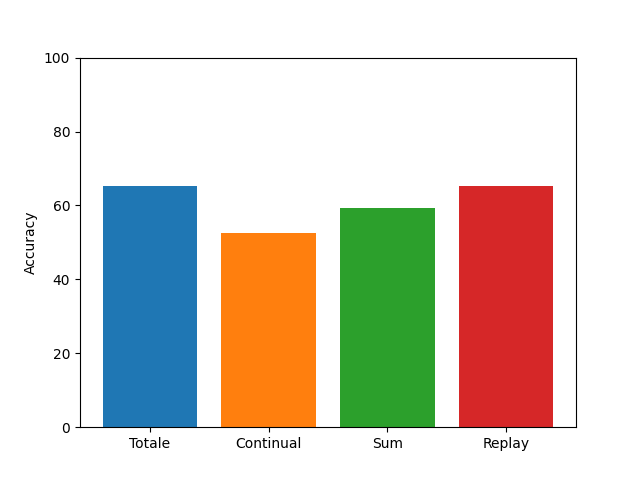

Ulteriore conferma di un risultato teorico: mantenere esempi già addestrati mitiga il catastrophic forgetting.
Nel caso del __continual training__ senza ripetizioni, si ha una costante diminuzione dell'accuracy su S17 che è sintomo di catastrophic forgetting, mentre il __sum training__ suppongo vada in overfitting per i troppi dati. __Replay__, d'altro canto, si comporta al pari del __total training__, pur mantenendo di coppia in coppia solo il 25% dei dati dei soggetti precedenti. Provo a diminuire questa percentuale, portandola a 10% ottenendo:

`Media numero epoche: 39.43
Deviazione standard numero epoche: 43.51
Media tempo di addestramento: 542.36 s
Accuracy: [0.7002398371696472, 0.6211031079292297, 0.5767385959625244, 0.5959232449531555, 0.5887290239334106, 0.6678656935691833, 0.5347721576690674] %
Media accuracy: 61.22 %
Deviazione standard accuracy: 5.21 %`

Per stasera lancio un'altra gridsearch con il nuovo dataset, per vedere se trova un modello migliore.

`Best: 1.000000 using {'units': 28, 'layers': 1, 'kernel_regularizer': 0.0001, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001}`

#### 29 Giugno 2021

L'auto search con il nuovo modello ha dato risultati peggiori:

`TOTAL TRAINING
Numero epoche: 19.0
Media tempo di addestramento: 166.16 s
Accuracy: 57.43 %`

`CONTINUAL TRAINING
Media numero epoche: 42.14
Deviazione standard numero epoche: 36.42
Media tempo di addestramento: 296.63 s
Accuracy: [0.5959232449531555, 0.6270983219146729, 0.5491606593132019, 0.5563549399375916, 0.6247002482414246, 0.541966438293457, 0.46882495284080505] %
Media accuracy: 56.63 %
Deviazione standard accuracy: 5.14 %`

`SUM TRAINING
Media numero epoche: 17.86
Deviazione standard numero epoche: 10.68
Media tempo di addestramento: 628.42 s
Accuracy: [0.6630695462226868, 0.5995203852653503, 0.5611510872840881, 0.5719424486160278, 0.5839328765869141, 0.5671463012695312, 0.5635491609573364] %
Media accuracy: 58.72 %
Deviazione standard accuracy: 3.34 %`

`REPLAY TRAINING
Media numero epoche: 31.57
Deviazione standard numero epoche: 15.17
Media tempo di addestramento: 315.78 s
Accuracy: [0.6151078939437866, 0.5875299572944641, 0.5587530136108398, 0.564748227596283, 0.577937662601471, 0.5239807963371277, 0.5635491609573364] %
Media accuracy: 57.02 %
Deviazione standard accuracy: 2.6 %`

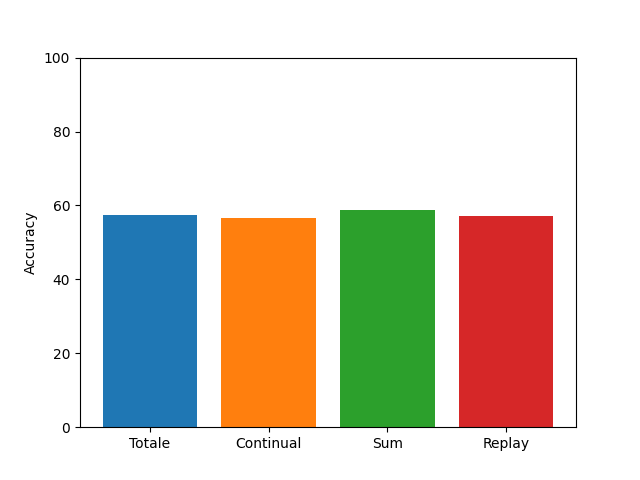

Per cui ho deciso di lasciare il modello con un singolo layer GRU da 30 neuroni.

Ora studio un po' diverse tecniche di replay, con la rete da un solo layer GRU a 30 unità (+ output Dense con 4 unità softmax)

__Baseline__: quella usata fin'ora, ma mantengo solo il 10%

`Media numero epoche: 58.43
Deviazione standard numero epoche: 35.66
Media tempo di addestramento: 391.29 s
Accuracy: [0.6127098202705383, 0.6115108132362366, 0.5695443749427795, 0.3824940025806427, 0.5083932876586914, 0.5155875086784363, 0.4076738655567169] %
Media accuracy: 51.54 %
Deviazione standard accuracy: 8.53 %`

__25%__ del trset mantenuto:

`Media numero epoche: 42.71
Deviazione standard numero epoche: 39.88
Media tempo di addestramento: 356.65 s
Accuracy: [0.6067146062850952, 0.5527577996253967, 0.5623500943183899, 0.568345308303833, 0.6954436302185059, 0.5011990666389465, 0.41127097606658936] %
Media accuracy: 55.69 %
Deviazione standard accuracy: 8.12 %`

__Mantengo $m = 50$ esempi per ogni label__:

`Media numero epoche: 45.43
Deviazione standard numero epoche: 41.74
Media tempo di addestramento: 347.46 s
Accuracy: [0.6306954622268677, 0.577937662601471, 0.6151078939437866, 0.5563549399375916, 0.49040767550468445, 0.5383692979812622, 0.5431654453277588] %
Media accuracy: 56.46 %
Deviazione standard accuracy: 4.44 %`

__Mantengo $m = 50$ predizioni di ogni label__:

`Media numero epoche: 23.0
Deviazione standard numero epoche: 32.16
Media tempo di addestramento: 205.55 s
Accuracy: [0.6378896832466125, 0.6438848972320557, 0.5719424486160278, 0.5995203852653503, 0.5335731506347656, 0.5455635786056519, 0.45803356170654297] %
Media accuracy: 57.01 %
Deviazione standard accuracy: 6.02 %`

Proviamo il solito test ma con un layer LSTM

__Baseline__ 10%

`Media numero epoche: 26.71
Deviazione standard numero epoche: 25.63
Media tempo di addestramento: 214.22 s
Accuracy: [0.6582733988761902, 0.564748227596283, 0.5527577996253967, 0.5467625856399536, 0.5743405222892761, 0.5083932876586914, 0.3225419521331787] %
Media accuracy: 53.25 %
Deviazione standard accuracy: 9.55 %`

__25%__ del trset mantenuto:

`Media numero epoche: 51.57
Deviazione standard numero epoche: 40.31
Media tempo di addestramento: 434.67 s
Accuracy: [0.7266187071800232, 0.5803357362747192, 0.5563549399375916, 0.5719424486160278, 0.7110311985015869, 0.623501181602478, 0.5239807963371277] %
Media accuracy: 61.34 %
Deviazione standard accuracy: 7.22 %`

__Mantengo $m = 50$ esempi per ogni label__:

`Media numero epoche: 24.0
Deviazione standard numero epoche: 17.74
Media tempo di addestramento: 233.8 s
Accuracy: [0.6007194519042969, 0.49040767550468445, 0.5767385959625244, 0.6618704795837402, 0.6019184589385986, 0.6702637672424316, 0.7829736471176147] %
Media accuracy: 62.63 %
Deviazione standard accuracy: 8.44 %`

__Mantengo $m = 50$ predizioni di ogni label__:

`Media numero epoche: 40.43
Deviazione standard numero epoche: 34.5
Media tempo di addestramento: 326.79 s
Accuracy: [0.6534771919250488, 0.564748227596283, 0.5383692979812622, 0.5359712243080139, 0.5947242379188538, 0.5299760103225708, 0.3908872902393341] %
Media accuracy: 54.40 %
Deviazione standard accuracy: 7.44 %`

#### 30 Giugno 2021

Autotest con LSTM

`TOTAL TRAINING
Numero epoche: 19.0
Media tempo di addestramento: 178.08 s
Accuracy: 69.42 %`

`CONTINUAL TRAINING
Media numero epoche: 37.43
Deviazione standard numero epoche: 33.77
Media tempo di addestramento: 280.99 s
Accuracy: [0.5671463012695312, 0.46043166518211365, 0.5443645119667053, 0.568345308303833, 0.568345308303833, 0.6294963955879211, 0.6067146062850952] %
Media accuracy: 56.35 %
Deviazione standard accuracy: 4.97 %`

`CUMULATIVE TRAINING
Media numero epoche: 28.14
Deviazione standard numero epoche: 30.79
Media tempo di addestramento: 672.7 s
Accuracy: [0.6187050342559814, 0.5959232449531555, 0.5707433819770813, 0.5443645119667053, 0.5935251712799072, 0.5731415152549744, 0.541966438293457] %
Media accuracy: 57.69 %
Deviazione standard accuracy: 2.6 %`

`REPLAY TRAINING
Media numero epoche: 19.43
Deviazione standard numero epoche: 16.92
Media tempo di addestramento: 222.84 s
Accuracy: [0.6546762585639954, 0.5587530136108398, 0.5515587329864502, 0.5527577996253967, 0.5899280309677124, 0.6163069605827332, 0.41127097606658936] %
Media accuracy: 56.220000000000006 %
Deviazione standard accuracy: 7.1 %`

`EPISODIC TRAINING
Media numero epoche: 20.71
Deviazione standard numero epoche: 32.69
Media tempo di addestramento: 183.8 s
Accuracy: [0.5887290239334106, 0.4208633005619049, 0.564748227596283, 0.46522781252861023, 0.577937662601471, 0.5731415152549744, 0.4724220633506775] %
Media accuracy: 52.33 %
Deviazione standard accuracy: 6.32 %`

Autotest con GRU

`TOTAL TRAINING
Numero epoche: 16.0
Media tempo di addestramento: 147.92 s
Accuracy: 47.24 %`

`CONTINUAL TRAINING
Media numero epoche: 86.14
Deviazione standard numero epoche: 33.94
Media tempo di addestramento: 500.73 s
Accuracy: [0.6031175255775452, 0.5851318836212158, 0.5575539469718933, 0.5671463012695312, 0.48441246151924133, 0.5731415152549744, 0.3956834673881531] %
Media accuracy: 53.800000000000004 %
Deviazione standard accuracy: 6.77 %`

`CUMULATIVE TRAINING
Media numero epoche: 27.43
Deviazione standard numero epoche: 33.12
Media tempo di addestramento: 617.59 s
Accuracy: [0.6378896832466125, 0.61031174659729, 0.6067146062850952, 0.6079136729240417, 0.5659472346305847, 0.577937662601471, 0.5755395889282227] %
Media accuracy: 59.75 %
Deviazione standard accuracy: 2.35 %`

`REPLAY TRAINING
Media numero epoche: 39.14
Deviazione standard numero epoche: 34.27
Media tempo di addestramento: 325.98 s
Accuracy: [0.6258992552757263, 0.785371720790863, 0.6115108132362366, 0.6115108132362366, 0.6151078939437866, 0.5395683646202087, 0.4976019263267517] %
Media accuracy: 61.24000000000001 %
Deviazione standard accuracy: 8.33 %`

`EPISODIC TRAINING
Media numero epoche: 41.14
Deviazione standard numero epoche: 37.23
Media tempo di addestramento: 316.2 s
Accuracy: [0.6474820375442505, 0.597122311592102, 0.5911270976066589, 0.5443645119667053, 0.7002398371696472, 0.37889689207077026, 0.3141486942768097] %
Media accuracy: 53.910000000000004 %
Deviazione standard accuracy: 13.100000000000001 %`

Le strategie "continual" si comportano meglio con GRU, mentre LSTM funziona meglio sul training offline.

Il prossimo test è vedere come cambia il training episodico al variare di $m$: proverò valori da 30 a 70 a ritmi di 10.

$m = 30$

`Media numero epoche: 54.0
Deviazione standard numero epoche: 40.07
Media tempo di addestramento: 395.54 s
Accuracy: [0.6019184589385986, 0.5203837156295776, 0.5803357362747192, 0.5791366696357727, 0.5899280309677124, 0.47122302651405334, 0.37889689207077026] %
Media accuracy: 53.169999999999995 %
Deviazione standard accuracy: 7.57 %`

$m = 40$

`Media numero epoche: 61.14
Deviazione standard numero epoche: 44.2
Media tempo di addestramento: 403.0 s
Accuracy: [0.6115108132362366, 0.5827338099479675, 0.5995203852653503, 0.5827338099479675, 0.7553957104682922, 0.6019184589385986, 0.6127098202705383] %
Media accuracy: 62.09 %
Deviazione standard accuracy: 5.6000000000000005 %`

$m = 50$

`Media numero epoche: 39.14
Deviazione standard numero epoche: 42.8
Media tempo di addestramento: 274.43 s
Accuracy: [0.6678656935691833, 0.6258992552757263, 0.7002398371696472, 0.5059952139854431, 0.43884891271591187, 0.45443645119667053, 0.35971224308013916] %
Media accuracy: 53.61 %
Deviazione standard accuracy: 11.98 %`

$m = 60$

`Media numero epoche: 66.57
Deviazione standard numero epoche: 33.97
Media tempo di addestramento: 470.2 s
Accuracy: [0.5611510872840881, 0.5611510872840881, 0.5623500943183899, 0.5707433819770813, 0.5095923542976379, 0.44364508986473083, 0.3549160659313202] %
Media accuracy: 50.91 %
Deviazione standard accuracy: 7.57 %`

$m = 70$

`Media numero epoche: 43.14
Deviazione standard numero epoche: 40.35
Media tempo di addestramento: 330.76 s
Accuracy: [0.6067146062850952, 0.6007194519042969, 0.5767385959625244, 0.730215847492218, 0.6834532618522644, 0.6067146062850952, 0.5743405222892761] %
Media accuracy: 62.56 %
Deviazione standard accuracy: 5.43 %`

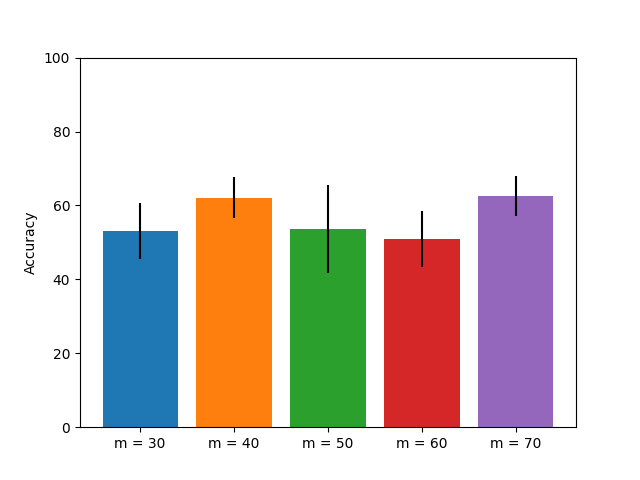

#### 1 Luglio 2021

Ho provato a implementare le metriche di misurazione dell'accuracy, forward transfer e backward transfer specificate in <a href="https://proceedings.neurips.cc/paper/2017/file/f87522788a2be2d171666752f97ddebb-Paper.pdf">questo paper</a>

In particolare, ho diviso il test set per task:

In [ ]:
Xts = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/XS17_disarli.pkl", 'rb'), encoding='latin1')
yts = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/yS17_disarli.pkl", 'rb'), encoding='latin1')

Xts_1, Xts_2, Xts_3, Xts_4, yts_1, yts_2, yts_3, yts_4 = [], [], [], [], [], [], [], []
idx_1 = [i for i, x in enumerate(yts) if x[0] == 1]
for i in idx_1:
    Xts_1.append(Xts[i])
    yts_1.append([1., 0., 0., 0.])
Xts_1, yts_1 = np.array(Xts_1), np.array(yts_1)
idx_2 = [i for i, x in enumerate(yts) if x[1] == 1]
for i in idx_2:
    Xts_2.append(Xts[i])
    yts_2.append([0., 1., 0., 0.])
Xts_2, yts_2 = np.array(Xts_2), np.array(yts_2)
idx_3 = [i for i, x in enumerate(yts) if x[2] == 1]
for i in idx_3:
    Xts_3.append(Xts[i])
    yts_3.append([0., 0., 1., 0.])
Xts_3, yts_3 = np.array(Xts_3), np.array(yts_3)
idx_4 = [i for i, x in enumerate(yts) if x[3] == 1]
for i in idx_4:
    Xts_4.append(Xts[i])
    yts_4.append([0., 0., 0., 1.])
Xts_4, yts_4 = np.array(Xts_4), np.array(yts_4)

Subito dopo il `model.compile()`, ho creato la matrice R, il vettore di valutazioni iniziali b e inizializzato T, ACC, BWT e FWT:

In [ ]:
R = []
T = 4
b = [model.evaluate(Xts_1, yts_1, verbose = 0)[1], model.evaluate(Xts_2, yts_2, verbose = 0)[1], model.evaluate(Xts_3, yts_3, verbose = 0)[1], model.evaluate(Xts_4, yts_4, verbose = 0)[1]]
ACC, BWT, FWT = 0, 0, 0

Durante il continual training, quindi all'interno del `for`, ho valutato oltre che su tutto il test set anche sui test set per task:

In [ ]:
R.append([model.evaluate(Xts_1, yts_1, verbose = 0)[1], model.evaluate(Xts_2, yts_2, verbose = 0)[1], model.evaluate(Xts_3, yts_3, verbose = 0)[1], model.evaluate(Xts_4, yts_4, verbose = 0)[1]])

Prima del precedente codice per popolare le memorie episodiche per task ($m = 70$ dai test di ieri).

Finito il training, calcolo e stampo le tre metriche:

In [ ]:
t = 0
for i in range(T):
        t += R[T-1][i]
ACC = t/T

t = 0
for i in range(T-1):
        t += (R[T-1][i] - R[i][i])
BWT = t/(T-1)

t = 0
for i in range(1, T):
        t += (R[i-1][i] - b[i])
FWT = t/(T-1)


print('ACC\t', np.around(ACC, 4))
print('BWT\t', np.around(BWT, 4))
print('FWT\t', np.around(FWT, 4))

Un rapido test sull'episodic training, con un layer GRU da 30 unità e $m = 70$, fornisce:

`Media numero epoche: 20.29
Deviazione standard numero epoche: 16.21
Media tempo di addestramento: 194.99 s
Accuracy: [0.6570743322372437, 0.7050359845161438, 0.5695443749427795, 0.5527577996253967, 0.5767385959625244, 0.6079136729240417, 0.5179855823516846] %
Media accuracy: 59.81999999999999 %
Deviazione standard accuracy: 5.949999999999999 %
ACC      0.4665
BWT      -0.0202
FWT      0.4069`

Mentre sul replay training al 10% ottengo:

`Media numero epoche: 46.14
Deviazione standard numero epoche: 42.93
Media tempo di addestramento: 373.96 s
Accuracy: [0.646282970905304, 0.8429256677627563, 0.5959232449531555, 0.5599520206451416, 0.6031175255775452, 0.5887290239334106, 0.3333333432674408] %
Media accuracy: 59.58 %
Deviazione standard accuracy: 13.83 %
ACC      0.4745
BWT      -0.1617
FWT      0.532`

e sul continual training classico:

`Media numero epoche: 48.29
Deviazione standard numero epoche: 37.38
Media tempo di addestramento: 589.17 s
Accuracy: [0.6055155992507935, 0.27697840332984924, 0.5071942210197449, 0.5563549399375916, 0.35371702909469604, 0.5539568066596985, 0.3968825042247772] %
Media accuracy: 46.44 %
Deviazione standard accuracy: 11.35 %
ACC      0.4813
BWT      -0.0242
FWT      0.0481`

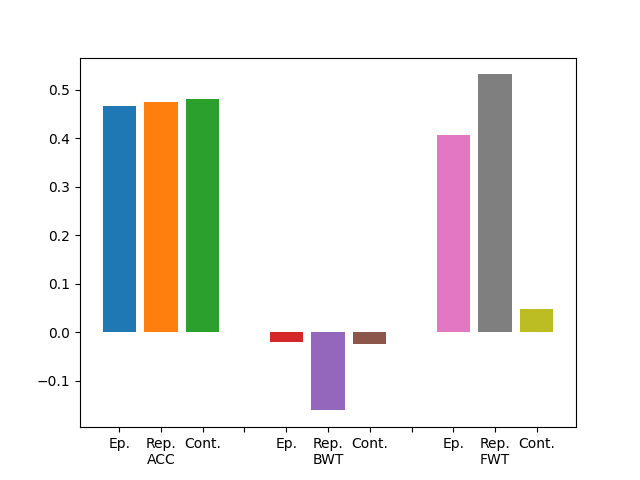

Proviamo il tutto ma imparando una classe alla volta.

`TOTAL TRAINING
Numero epoche: 18.0
Media tempo di addestramento: 171.14 s
Accuracy: 53.239999999999995 %`

`CONTINUAL TRAINING
Media numero epoche: 99.25
Deviazione standard numero epoche: 1.3
Media tempo di addestramento: 553.84 s
Accuracy: [0.4532374143600464, 0.44964027404785156, 0.14268584549427032, 0.13309352099895477] %
Media accuracy: 29.470000000000002 %
Deviazione standard accuracy: 15.68 %
ACC      0.257
BWT      -0.9907
FWT      -0.0935`

`CUMULATIVE TRAINING
Media numero epoche: 99.25
Deviazione standard numero epoche: 1.3
Media tempo di addestramento: 558.1 s
Accuracy: [0.568345308303833, 0.3992805778980255, 0.20863309502601624, 0.12949639558792114] %
Media accuracy: 32.64 %
Deviazione standard accuracy: 17.07 %
ACC      0.2507
BWT      -0.9991
FWT      -0.3965`

`REPLAY TRAINING 25%
Media numero epoche: 99.0
Deviazione standard numero epoche: 1.73
Media tempo di addestramento: 563.53 s
Accuracy: [0.47122302651405334, 0.35971224308013916, 0.21462829411029816, 0.20383693277835846] %
Media accuracy: 31.240000000000002 %
Deviazione standard accuracy: 11.05 %
ACC      0.2918
BWT      -0.9443
FWT      -0.3756`

`EPISODIC TRAINING m = 70
Media numero epoche: 39.5
Deviazione standard numero epoche: 36.13
Media tempo di addestramento: 329.7 s
Accuracy: [0.45203837752342224, 0.6402877569198608, 0.5899280309677124, 0.577937662601471] %
Media accuracy: 56.49999999999999 %
Deviazione standard accuracy: 6.93 %
ACC      0.4938
BWT      -0.6509
FWT      -0.3595`

Un confronto con l'autotest per coppia di soggetti

`TOTAL TRAINING
Numero epoche: 13.0
Media tempo di addestramento: 130.07 s
Accuracy: 59.95 %`

`CONTINUAL TRAINING
Media numero epoche: 70.0
Deviazione standard numero epoche: 37.04
Media tempo di addestramento: 419.44 s
Accuracy: [0.6258992552757263, 0.5251798629760742, 0.44724220037460327, 0.5599520206451416, 0.4748201370239258, 0.5503597259521484, 0.5239807963371277] %
Media accuracy: 52.959999999999994 %
Deviazione standard accuracy: 5.41 %
ACC      0.4712
BWT      -0.0042
FWT      0.0844`

`CUMULATIVE TRAINING
Media numero epoche: 24.71
Deviazione standard numero epoche: 27.54
Media tempo di addestramento: 547.2 s
Accuracy: [0.6007194519042969, 0.824940025806427, 0.5839328765869141, 0.5743405222892761, 0.5671463012695312, 0.5887290239334106, 0.5215827226638794] %
Media accuracy: 60.88 %
Deviazione standard accuracy: 9.13 %
ACC      0.4837
BWT      -0.1369
FWT      0.3752`

`25% REPLAY TRAINING
Media numero epoche: 49.14
Deviazione standard numero epoche: 35.97
Media tempo di addestramento: 385.25 s
Accuracy: [0.7482014298439026, 0.5563549399375916, 0.5911270976066589, 0.5731415152549744, 0.7422062158584595, 0.6606714725494385, 0.5239807963371277] %
Media accuracy: 62.8 %
Deviazione standard accuracy: 8.36 %
ACC      0.4835
BWT      -0.0399
FWT      0.4332`

`EPISODIC TRAINING m = 70
Media numero epoche: 56.29
Deviazione standard numero epoche: 35.27
Media tempo di addestramento: 367.09 s
Accuracy: [0.7026379108428955, 0.5755395889282227, 0.5719424486160278, 0.5827338099479675, 0.6498801112174988, 0.6223021745681763, 0.5119904279708862] %
Media accuracy: 60.24 %
Deviazione standard accuracy: 5.72 %
ACC      0.4942
BWT      -0.0502
FWT      0.3903`

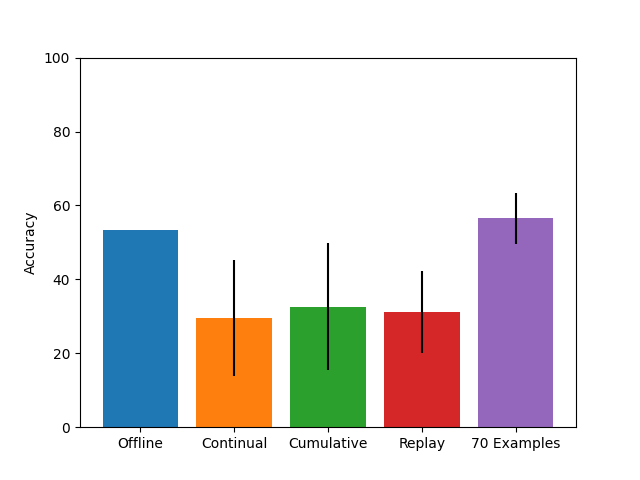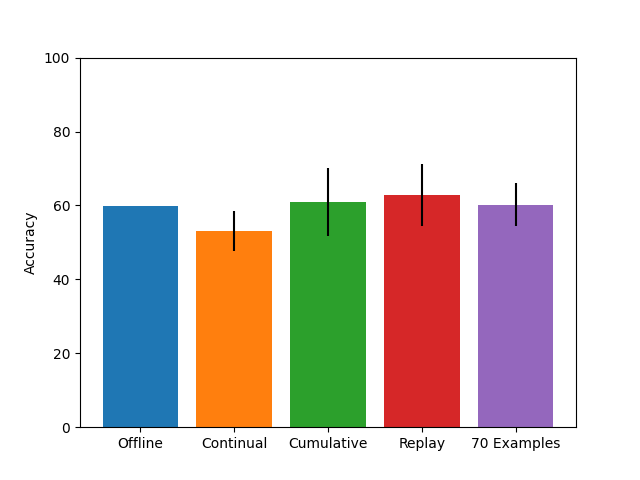

#### 2 Luglio 2021

##### Un po' di somme
Dopo un mesetto di test mi fermo un secondo e tiro qualche somma rivedendo i dati.

Partendo da un layer GRU da 29 unità seguito da un layer output Dense da 4 unità softmax, ho innanzitutto provato tre tecniche:
- __Total training__: tutti i soggetti (escluso S17) sono stati uniti in un unico dataset e il modello è stato addestrato offline e testato su S17.
- __Continual training__: i soggetti sono stati divisi a coppie, escluso S17, e il modello è stato addestrato coppia per coppia testando su S17 dopo ogni coppia.
- __Cumulative training__: il training è stato eseguito coppia per coppia, ma le coppie precedentemente usate sono state mantenute anche nei training set successivi (quindi a con l'ultima coppia il training set equivaleva al dataset completo escluso S17)

Ho poi provato un modello con due layer GRU da 30 unità e un layer output Dense da 4 unità softmax sui primi due scenari di training, ottenendo fondamentalmente gli stessi risultati. Temendo overfitting, ho rifatto il dataset prendendo tutti i datapoint di ogni soggetto invece che solo una parte. Con quest'ultimo modello, sul dataset nuovo, ho ottenuto risultati migliori raggiungendo un 56% di accuratezza sul training offline e un 53% su quello continual.

Quindi ho provato un modello con due layer LSTM da 30 unità e un layer output Dense da 4 unità softmax, ottenendo risultati ancora migliori sui tre scenari. Ho aggiunto un nuovo scenario:
- __Replay training__: dopo aver usato una coppia, ne mantengo il 25% (default) dai dati da usare nel training assieme alla coppia successiva. Fornisce risultati a metà strada tra il continual e il cumulative.

Con la nuova tecnica, ho provato diversi modelli sia GRU che LSTM con un numero di unità tra i 30 e i 15. Ho concluso che il modello con un singolo layer LSTM da 30 unità e quello con un singolo layer GRU da 30 unità sono i migliori, procedendo a comparare le varie tecniche sul singolo layer GRU. Ottengo un comportamento del replay al 25% comparabile al training offline, seppur oscillante tra l'85% e il 55% (con l'offline che si attesta sul 65%). Il cumulative è molto più stabile, intorno al 60% con una deviazione standard del 2%.

Giudicando ottime le tecniche di replay, ne ho provate diverse:
- __Replay 10%__
- __Replay 25%__
- __Episodica $m = 50$__ istanze
- __Episodica $m = 50$__ predizioni

Con il replay al 25% e l'episodico sulle istanze con i comportamenti migliori. Ho provato anche con un layer LSTM da 30 unità e un layer output Dense da 4 unità softmax, ottenendo risultati simili ma migliori.

Ho confrontato i due modelli, ottenendo un risultato migliore su LSTM per il training offline, mentre le strategie continual si comportano meglio con GRU. Va però in contrasto con quanto osservato fin'ora.

Confrontando vari valori di $m$, ho trovato in $m = 70$ il comportamento migliore. Andrebbe fatta un'altra ricerca in quell'intorno, magari tra 60 e 100.

Successivamente ho studiato diverse metriche (ACC, BWT e FWT) che confermano l'episodic come la tecnica migliore: finendo con un'ACC comparabile al replay al 10%, ha però un catastrophic forgetting di quasi 10 volte inferiore.

Ho anche comparato l'apprendere task per task invece che coppia per coppia, ottenendo però accuratezze molto basse su continual, cumulative e replay, nonostante l'offline (dove il dataset non cambia) e l'episodic mantengano grossomodo le stesse capacità.

`TOTAL TRAINING (GRU)
Numero epoche: 31.0
Media tempo di addestramento: 228.87 s
Accuracy: 57.07 %`

`CONTINUAL TRAINING (GRU)
Media numero epoche: 86.0
Deviazione standard numero epoche: 33.08
Media tempo di addestramento: 492.29 s
Accuracy: [0.6079136729240417, 0.5335731506347656, 0.5059952139854431, 0.5467625856399536, 0.39808154106140137, 0.5167865753173828, 0.3633093535900116] %
Media accuracy: 49.61 %
Deviazione standard accuracy: 7.95 %
ACC      0.4379
BWT      -0.0133
FWT      0.0702`

`CUMULATIVE TRAINING (GRU)
Media numero epoche: 12.57
Deviazione standard numero epoche: 9.5
Media tempo di addestramento: 429.33 s
Accuracy: [0.619904100894928, 0.7098321318626404, 0.6091127395629883, 0.597122311592102, 0.6067146062850952, 0.5023980736732483, 0.5671463012695312] %
Media accuracy: 60.17 %
Deviazione standard accuracy: 5.75 %
ACC      0.5287
BWT      -0.0219
FWT      0.4732`

`25% REPLAY TRAINING (GRU)
Media numero epoche: 49.43
Deviazione standard numero epoche: 33.97
Media tempo di addestramento: 452.58 s
Accuracy: [0.6438848972320557, 0.7637889981269836, 0.581534743309021, 0.5731415152549744, 0.5851318836212158, 0.5767385959625244, 0.5983213186264038] %
Media accuracy: 61.75000000000001 %
Deviazione standard accuracy: 6.370000000000001 %
ACC      0.486
BWT      -0.1744
FWT      0.3707`

`EPISODIC TRAINING (m = 70) (GRU)
Training        ended
Media numero epoche: 42.43
Deviazione standard numero epoche: 39.91
Media tempo di addestramento: 341.32 s
Accuracy: [0.7817745804786682, 0.5695443749427795, 0.5671463012695312, 0.526378870010376, 0.5695443749427795, 0.5587530136108398, 0.22781774401664734] %
Media accuracy: 54.300000000000004 %
Deviazione standard accuracy: 15.07 %
ACC      0.4501
BWT      -0.0573
FWT      0.5017`

`TOTAL TRAINING (LSTM)
Numero epoche: 25.0
Media tempo di addestramento: 189.37 s
Accuracy: 50.6 %`

`CONTINUAL TRAINING (LSTM)
Media numero epoche: 65.14
Deviazione standard numero epoche: 37.06
Media tempo di addestramento: 431.68 s
Accuracy: [0.5803357362747192, 0.4076738655567169, 0.47122302651405334, 0.6474820375442505, 0.6139088869094849, 0.5239807963371277, 0.29136690497398376] %
Media accuracy: 50.51 %
Deviazione standard accuracy: 11.62 %
ACC      0.5555
BWT      0.1009
FWT      0.1348`

`CUMULATIVE TRAINING (LSTM)
Media numero epoche: 14.0
Deviazione standard numero epoche: 9.83
Media tempo di addestramento: 452.7 s
Accuracy: [0.5059952139854431, 0.6067146062850952, 0.5599520206451416, 0.581534743309021, 0.6438848972320557, 0.555155873298645, 0.5431654453277588] %
Media accuracy: 57.089999999999996 %
Deviazione standard accuracy: 4.15 %
ACC      0.5026
BWT      -0.0568
FWT      0.197`

`25% REPLAY TRAINING (LSTM)
Media numero epoche: 8.0
Deviazione standard numero epoche: 4.17
Media tempo di addestramento: 116.93 s
Accuracy: [0.7817745804786682, 0.7242206335067749, 0.5755395889282227, 0.568345308303833, 0.6223021745681763, 0.6402877569198608, 0.6318944692611694] %
Media accuracy: 64.92 %
Deviazione standard accuracy: 7.199999999999999 %
ACC      0.4893
BWT      -0.2733
FWT      0.459`

`EPISODIC TRAINING (m = 70) (LSTM)
Media numero epoche: 15.0
Deviazione standard numero epoche: 10.32
Media tempo di addestramento: 149.23 s
Accuracy: [0.6822541952133179, 0.6570743322372437, 0.4892086386680603, 0.5107913613319397, 0.6151078939437866, 0.49640288949012756, 0.4772182106971741] %
Media accuracy: 56.120000000000005 %
Deviazione standard accuracy: 8.08 %
ACC      0.4055
BWT      -0.055
FWT      0.0749`

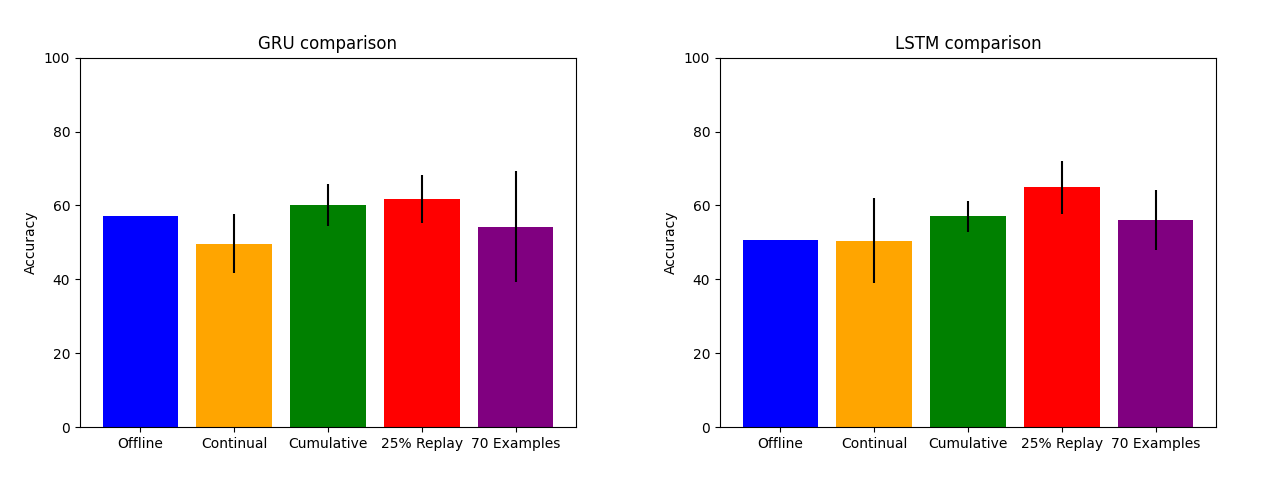

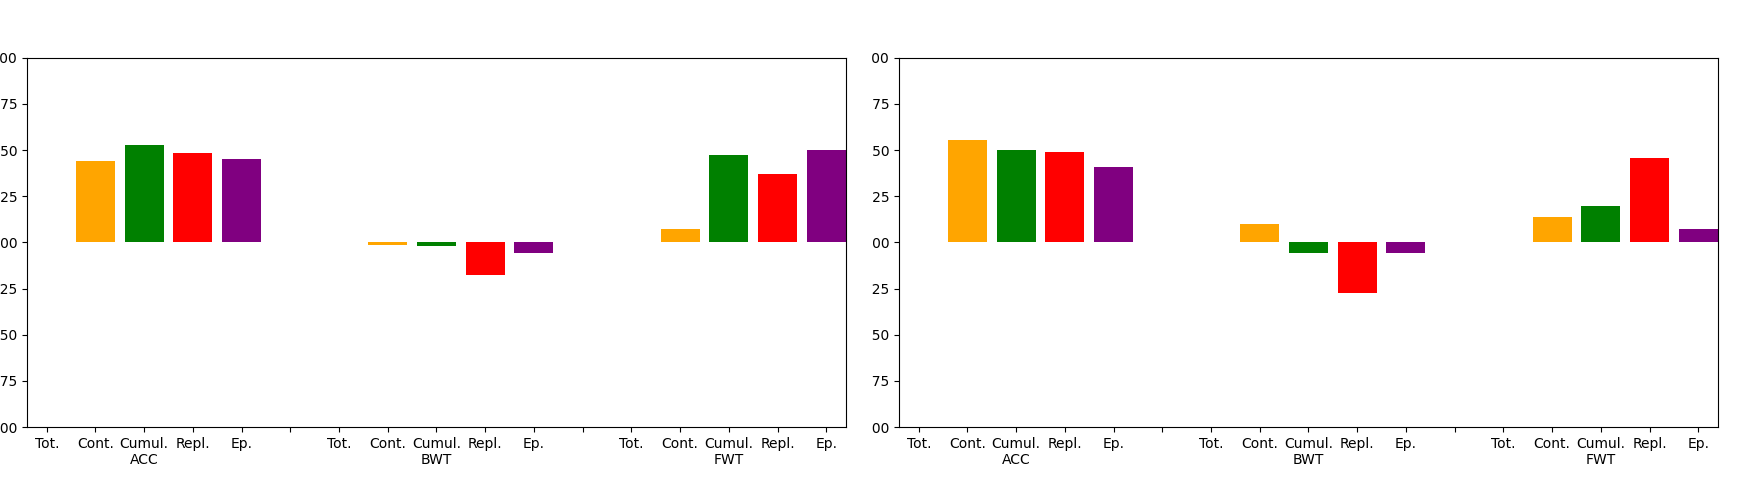

#### 3 Luglio 2021

Ho pensato di aver sistemato male i dati, e aggiornato `data.py` calcolando media e deviazione standard sull'intero dataset invece di standardizzare soggetto per soggetto. Fatto sta che il training offline supera a malapena il 25% di accuratezza su S17 così facendo, per cui sono tornato al dataset precedente.

##### CLEAR
_Continual Learning with Experience and Replay_

_As read <a href="https://arxiv.org/pdf/1811.11682.pdf">here</a>_
- __Stability-Plasticity dilemma__: contrapposizione di due vincoli, cioè del mantenere la vecchia conoscenza sapendosi adattate al nuovo
- __Catastrophic Forgetting__: nuova conoscenza soppianta la vecchia (alta plasticità ma bassa stabilità)

CLEAR unisce learning on-policy da nuove esperienze (plasticità) e learning off-policy da esperienze in replay (stabilità). Per stabilità aggiuntiva, si introduce behavioral cloning tra policy attuale e sé stesso del passato.
- Stabilità e plasticità, quasi eliminando il catastrophic forgetting. Si comporta meglio di EWC e Progress&Compress.
- Semplicità, e può essere combinato con altri approcci
- Non si basa sull'identità del task o sui confini tra task, risultando applicabile laddove i task sono sconosciuti o non discreti.

##### Brain inspired replay
_As read <a href="https://www.nature.com/articles/s41467-020-17866-2">here</a>_

Valuto l'idea di creare un modello generativo per il replay. Semplice semplice: lo alleno "al contrario" (passando i label come dato e le 14 features come target) e vediamo come si comporta. Parto da un layer Dense con 30 neuroni input e un layer output da 14 neuroni senza attivazione.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30))
model.add(tf.keras.layers.Dense(14,
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'mse', optimizer = opt)

Allenato sull'intero dataset WESAD a disposizione con batch di 512 elementi, e testato su S17 con una loss di 0.9588.

Un velocissimo test　(`genvclas.py`)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np


generator = tf.keras.models.load_model('/home/fexed/ML/models/wesad_generative.h5')
classificator = tf.keras.models.load_model('/home/fexed/ML/models/autotest/episodicGRU')
first, second, third, fourth = [], [], [], []
for i in range(100):
    first.append(generator.predict(np.array([[1., 0., 0., 0.]]))[0])
    second.append(generator.predict(np.array([[0., 1., 0., 0.]]))[0])
    third.append(generator.predict(np.array([[0., 0., 1., 0.]]))[0])
    fourth.append(generator.predict(np.array([[0., 0., 0., 1.]]))[0])

first = np.array(first).reshape(-1, 100, 14)
second = np.array(second).reshape(-1, 100, 14)
third = np.array(third).reshape(-1, 100, 14)
fourth = np.array(fourth).reshape(-1, 100, 14)

print(classificator.predict(first))
print(classificator.predict(second))
print(classificator.predict(third))
print(classificator.predict(fourth))

Produce risultati confortanti

`[[9.9999845e-01 5.4661302e-07 6.5005071e-07 2.8123785e-07]]
[[9.4253558e-08 9.9999928e-01 1.1999366e-07 4.3563784e-07]]
[[1.9276902e-06 1.3294758e-07 9.9997914e-01 1.8861941e-05]]
[[1.3735850e-07 1.3718072e-07 7.1482100e-07 9.9999905e-01]]`

Quindi ho prodotto uno script che lavora come l'episodic ma si avvale del generatore per poter creare le etichette "replay". Provo una volta generando le etichette solo all'inizio, poi proverò rigenerando ogni volta le etichette.

In [ ]:
print("Opening generator")
generator = tf.keras.models.load_model('/home/fexed/ML/models/wesad_generative.h5')
print("Generating")
for i in range(m):
    print("m = " + str(i*100), end="\r")
    f, s, t, g = [], [], [], []
    for i in range(100):
        f.append(generator.predict(np.array([[1., 0., 0., 0.]]))[0])
        s.append(generator.predict(np.array([[0., 1., 0., 0.]]))[0])
        t.append(generator.predict(np.array([[0., 0., 1., 0.]]))[0])
        g.append(generator.predict(np.array([[0., 0., 0., 1.]]))[0])
    X_1.append(f)
    y_1.append([1., 0., 0., 0.])
    X_2.append(s)
    y_2.append([0., 1., 0., 0.])
    X_3.append(t)
    y_3.append([0., 0., 1., 0.])
    X_4.append(g)
    y_4.append([0., 0., 0., 1.])

X_gen = np.concatenate([X_1, X_2, X_3, X_4], axis = 0)
y_gen = np.concatenate([y_1, y_2, y_3, y_4], axis = 0)

for S in [("S2", "S3"), ("S4", "S5"), ("S6", "S7"), ("S8", "S9"), ("S10", "S11"), ("S13", "S14"), ("S15", "S16")]:
    print("Subjects " + S[0] + " and " + S[1])
    Xa = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    ya = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[0] + "_disarli.pkl", 'rb'), encoding='latin1')
    Xb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')
    yb = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S[1] + "_disarli.pkl", 'rb'), encoding='latin1')

    X = np.concatenate([X_gen, Xa, Xb], axis = 0)
    y = np.concatenate([y_gen, ya, yb], axis = 0)
    
    # Training...

Il risultato generando il test una sola volta è:

`Media numero epoche: 76.29
Deviazione standard numero epoche: 37.95
Media tempo di addestramento: 538.37 s
Accuracy: [0.6954436302185059, 0.6546762585639954, 0.5431654453277588, 0.6247002482414246, 0.4184652268886566, 0.4976019263267517, 0.46882495284080505] %
Media accuracy: 55.76 %
Deviazione standard accuracy: 9.56 %
ACC      0.5594
BWT      -0.0482
FWT      0.2269`

Generando di volta in volta:

`Media numero epoche: 60.14
Deviazione standard numero epoche: 44.95
Media tempo di addestramento: 574.32 s
Accuracy: [0.619904100894928, 0.633093535900116, 0.568345308303833, 0.6606714725494385, 0.4424460530281067, 0.44724220037460327, 0.33453238010406494] %
Media accuracy: 52.949999999999996 %
Deviazione standard accuracy: 11.34 %
ACC      0.5646
BWT      0.0117
FWT      -0.024`

#### 5 Luglio 2021

Ho sistemato il progetto su Overleaf e mandato una mail ai relatori.

Provo a generare un "test set" artificiale col generatore e valutare la performance di un modello su di esso: la loss è di `0.0003301` e l'accuracy misurata è del 100%

- __On-Policy__: algoritmi che valutano e migliorano la stessa _policy_ che viene usata per scegliere l'azione da eseguire. Target policy $=$ behavior policy.
- __Off-Policy__: algoritmi che valutano e migliorano una _policy_ diversa da quella usata per selezionare l'azione. Target policy $\neq$ behavior policy.
- policy sarebbe la probabilità che un'azione _a_ sia intrapresa in uno stato _s_

Provo la <a href="https://github.com/gallicch/DeepRC-TF">Deep Reservoir Echo State Network</a>. Script semplice semplice per provarla, allenamento offline (da `totaltrain.py`) con il modello costruito tramite `DeepRC.SimpleDeepESNClassifier(num_classes = 4, units = 30, layers = 1)`, il risultato è un 58.39% di accuratezza dopo 22 epoche (e 1h 20m di tempo).

Provo con 2 layers ed in 22 epoche raggiunge il 53.24% di accuratezza.

Provo con 1 layer da 15 unità: 31 epoche per 44%. Domani proverò con 25, 35 e 40 unità. La mattinata, praticamente.

#### 6 Luglio 2021

Proviamo un layer da 25 unità: 12 epoche per 40.53%

Un layer da 35 unità: 20 epoche per 59.96%

Un layer da 40 unità: 17 epoche per 53.6%

Un layer da 37 unità: 10 epoche per 67.99%

Un layer da 38 unità: 12 Epoche per 46.36%

Riprovo 37 unità: 65.47% in 23 epoche. Direi che va bene. Provo questo modello (un layer da 37 unità) con il replay episodico con $m = 70$

`Media numero epoche: 53.43
Deviazione standard numero epoche: 22.35
Media tempo di addestramento: 1894.45 s
Accuracy: [0.5743405222892761, 0.5851318836212158, 0.45443645119667053, 0.541966438293457, 0.6618704795837402, 0.5563549399375916, 0.30215826630592346] %
Media accuracy: 52.52 %
Deviazione standard accuracy: 10.74 %
ACC      0.4652
BWT      -0.0468
FWT      -0.0308`

#### 7 Luglio 2021

13h di elaborazione per l'autotest con il Reservoir.

`TOTAL TRAINING
Numero epoche: 35.0
Media tempo di addestramento: 1256.66 s
Accuracy: 66.31 %`

`CONTINUAL TRAINING
Media numero epoche: 73.29
Deviazione standard numero epoche: 25.97
Media tempo di addestramento: 2066.87 s
Accuracy: [0.5491606593132019, 0.49040767550468445, 0.44724220037460327, 0.5383692979812622, 0.5323740839958191, 0.5515587329864502, 0.4040767252445221] %
Media accuracy: 50.19 %
Deviazione standard accuracy: 5.3 %
ACC      0.4651
BWT      -0.0173
FWT      -0.0873`

`CUMULATIVE TRAINING
Media numero epoche: 19.71
Deviazione standard numero epoche: 10.82
Media tempo di addestramento: 2612.8 s
Accuracy: [0.6486810445785522, 0.623501181602478, 0.5947242379188538, 0.6378896832466125, 0.6402877569198608, 0.6618704795837402, 0.6726618409156799] %
Media accuracy: 63.99 %
Deviazione standard accuracy: 2.37 %
ACC      0.5465
BWT      0.0196
FWT      0.0829`

`25% REPLAY TRAINING
Media numero epoche: 33.43
Deviazione standard numero epoche: 17.12
Media tempo di addestramento: 1337.93 s
Accuracy: [0.678657054901123, 0.4976019263267517, 0.1558752954006195, 0.5539568066596985, 0.5467625856399536, 0.5875299572944641, 0.19904077053070068] %
Media accuracy: 45.99 %
Deviazione standard accuracy: 18.61 %
ACC      0.4658
BWT      -0.0089
FWT      0.4862`

`EPISODIC TRAINING (m = 70)
Media numero epoche: 36.71
Deviazione standard numero epoche: 15.53
Media tempo di addestramento: 1426.2 s
Accuracy: [0.6306954622268677, 0.7026379108428955, 0.4724220633506775, 0.36690646409988403, 0.5071942210197449, 0.5503597259521484, 0.6175059676170349] %
Media accuracy: 54.97 %
Deviazione standard accuracy: 10.4 %
ACC      0.3661
BWT      -0.247
FWT      0.4371`

#### 8 Luglio 2021
##### Call con Gallicchio e Lomonaco
https://teaching-gitlab.di.unipi.it/f.matteoni

- un soggetto per volta, partendo da zero sul cumulative (pesi random), verifica offline per numero di epoche ma uso early stopping e va già abbastanza bene.
- Continual learning applicato a human state monitoring
- Call con Gallicchio per vedere di risolvere lentezza Reservoir
- Altri dataset

Quindi opzioni sono
- irrobustire con dataset e scenari e altri metodi replay
- lato strategie, più originale
- provare su device vero, jetson nano

Quindi
- misurare tempi e memoria oltre le varie metriche
- consolidare con altri dataset (ASCERTAIN)

`0 = arousal > 3 & valence > 0,
1 = arousal > 3 & valence <= 0,
2 = arousal <= 3 & valence > 0,
3 = arousal <= 3 & valence <= 0.`

- altra strategia (EWC, LWF, altre simili)

##### Misurare memoria
https://pypi.org/project/memory-profiler/

https://www.pluralsight.com/blog/tutorials/how-to-profile-memory-usage-in-python `guppy`

https://stackoverflow.com/questions/276052/how-to-get-current-cpu-and-ram-usage-in-python `psutil`

#### 9 Luglio 2021

Ho fatto uno script che monitora la RAM usata da un processo in base al PID. Lo "aggancio" ai processi di training per misurare l'utilizzo di RAM e salvo i risultati.

In [ ]:
import threading
import os
import psutil
import signal
import sys


def signal_handler(sig, frame):
    import matplotlib.pyplot as plot
    plot.plot(data)
    plot.savefig("/home/fexed/ML/scripts/continual/plots/mem" + str(PID) + ".png")
    sys.exit(0)


def printit():
    threading.Timer(1.0, printit).start()
    try:
        mem = process.memory_info()[0]/1024/1024
        data.append(mem)
        print(mem)
    except FileNotFoundException:
        print("Processo concluso")


data = []
signal.signal(signal.SIGINT, signal_handler)
PID = int(sys.argv[1])
process = psutil.Process(PID)
printit()

Training offline

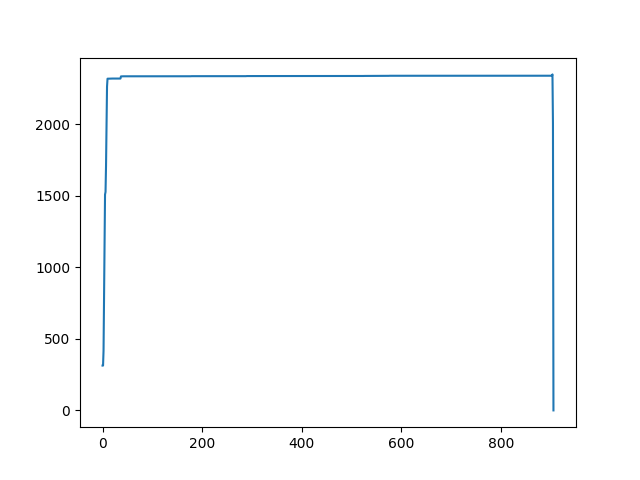

Continual training

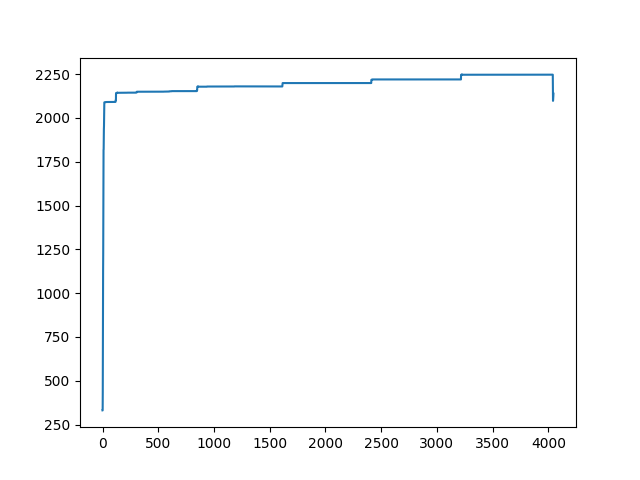

Cumulative training

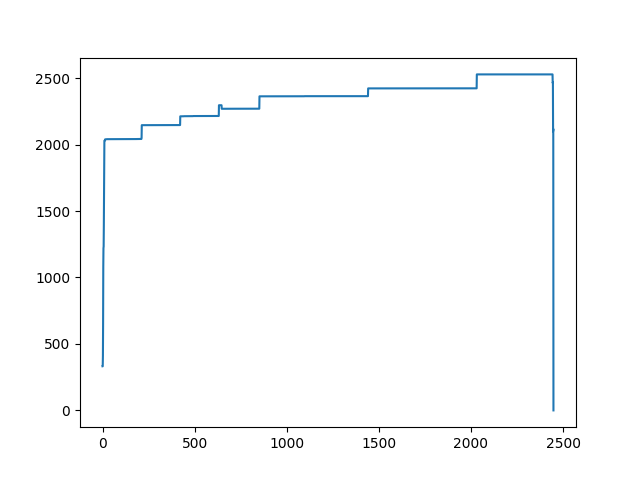

Replay training

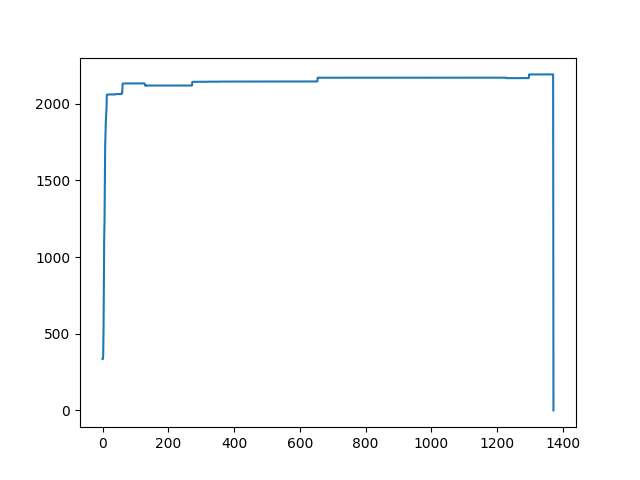

Episodic training

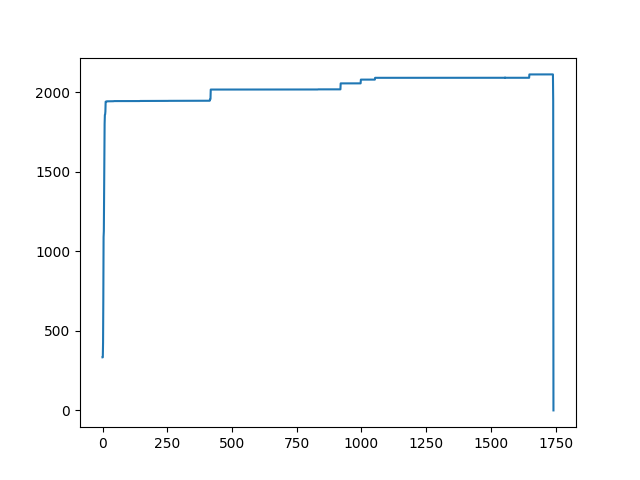

#### 10 Luglio 2021

##### Elastic Weight Consolidation
_As seen <a href="https://seanmoriarity.com/2020/10/18/continual-learning-with-ewc/">here</a>_

Ho implementato usando il codice specificato sopra e riadattandolo a WESAD (`ewc_train.py`). Ho anche richiesto l'accesso per il dataset ASCERTAIN, sperando rispondano entro pochi giorni (in caso contrario sentirò i relatori).

Per EWC ho fatto sia un continual normale sia un episodic, domani scrivo anche il replay e testo. Lunedì passo a implementare l'altra strategia.

#### 11 Luglio 2021

`EWC Continual
Media tempo di addestramento: 978.14 s
Accuracy: [0.675059974193573, 0.5671463012695312, 0.5575539469718933, 0.5503597259521484, 0.6954436302185059, 0.5923261642456055, 0.4040767252445221] %
Media accuracy: 57.74 %
Deviazione standard accuracy: 8.86 %
ACC      0.4684
BWT      -0.0473
FWT      0.0531`

`EWC Episodic
Media tempo di addestramento: 1077.42 s
Accuracy: [0.6187050342559814, 0.7002398371696472, 0.6055155992507935, 0.6294963955879211, 0.61031174659729, 0.7374100685119629, 0.6019184589385986] %
Media accuracy: 64.34 %
Deviazione standard accuracy: 4.95 %
ACC      0.5994
BWT      0.0476
FWT      0.6155`

`EWC Replay
Media tempo di addestramento: 1252.83 s
Accuracy: [0.6127098202705383, 0.6990407705307007, 0.5791366696357727, 0.5719424486160278, 0.5851318836212158, 0.5743405222892761, 0.4940047860145569] %
Media accuracy: 58.8 %
Deviazione standard accuracy: 5.65 %
ACC      0.4811
BWT      0.0012
FWT      -0.1693`

Un'altra run di replay da

`Media tempo di addestramento: 1184.21 s
Accuracy: [0.6270983219146729, 0.7817745804786682, 0.5755395889282227, 0.7314148545265198, 0.623501181602478, 0.5695443749427795, 0.564748227596283] %
Media accuracy: 63.91 %
Deviazione standard accuracy: 7.9 %
ACC      0.6277
BWT      0.0018
FWT      0.1613`

#### 12 Luglio 2021

Seguendo il paper relativo, <a href="https://arxiv.org/pdf/1606.09282.pdf">questo</a>, ho implementato LWF in una versione iniziale sicuramente problematica.

`Media tempo di addestramento: 3724.16 s
Accuracy: [0.6510791182518005, 0.5479616522789001, 0.5719424486160278, 0.6834532618522644, 0.44124701619148254, 0.633093535900116, 0.3033573031425476] %
Media accuracy: 54.74 %
Deviazione standard accuracy: 12.42 %
ACC      0.581
BWT      0.1284
FWT      0.0131`

#### 13 Luglio 2021

Ho sistemato l'early stopping sia in LWF che in EWC

`LWF
Media numero epoche: 86.71
Deviazione standard numero epoche: 21.61
Media tempo di addestramento: 2976.62 s
Accuracy: [0.6163069605827332, 0.5911270976066589, 0.5503597259521484, 0.6474820375442505, 0.5875299572944641, 0.6151078939437866, 0.29136690497398376] %
Media accuracy: 55.7 %
Deviazione standard accuracy: 11.200000000000001 %
ACC      0.5585
BWT      0.0722
FWT      -0.1078`

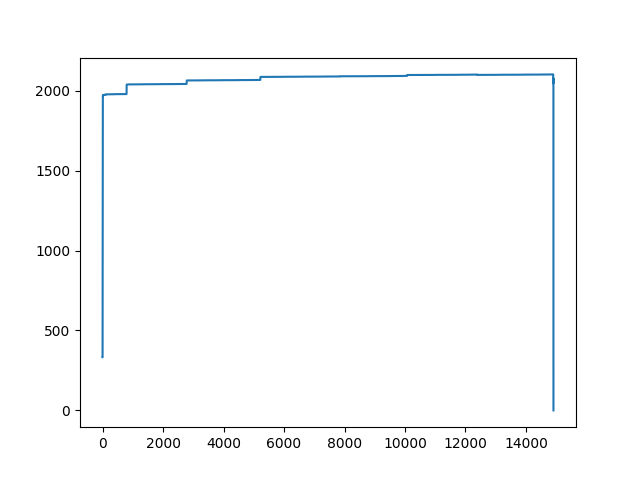

`EWC
Media numero epoche: 58.0
Deviazione standard numero epoche: 43.38
Media tempo di addestramento: 753.98 s
Accuracy: [0.6870503425598145, 0.5983213186264038, 0.5107913613319397, 0.3800959289073944, 0.2781774699687958, 0.555155873298645, 0.5035971403121948] %
Media accuracy: 50.19 %
Deviazione standard accuracy: 12.61 %
ACC      0.3646
BWT      -0.195
FWT      0.1902`

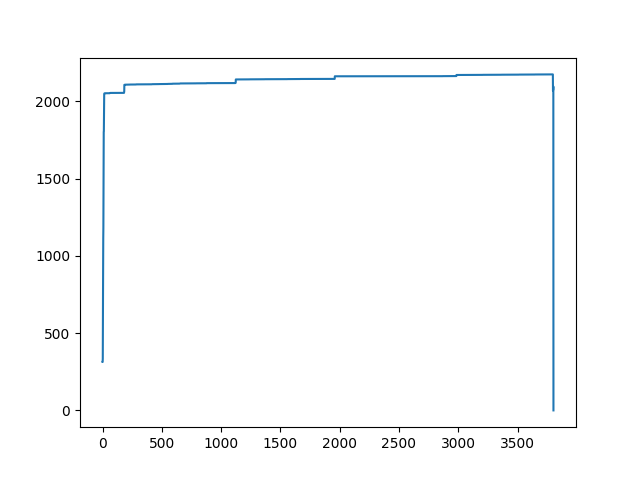

Nel frattempo mi hanno autorizzato l'accesso al dataset ASCERTAIN e ho scaricato i dati. Domani provvederò a sistemarlo.

#### 14 Luglio 2021

Ho preparato il dataset ASCERTAIN, con questo codice (`ascertain_data.py`) preso dal solito notebook di Disarli

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.signal
import pickle

ds_ECG, ds_EEG, ds_GSR = {}, {}, {}
arousal, valence = [], []
#Removing subjects with missing data
excluded_subjects = [44, 52]
#Excluding subjects data with poor accuracy & many nan values

print("Loading subjects...", end=" ")
for i in range(37, 57):
    if(i not in excluded_subjects):
        clips_ECG = {}
        for j in range(1, 37):
            clips_ECG[('n_' + str(j))] = scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/ECGData/Movie_P' + str(i) + '/ECG_Clip' + str(j))['Data_ECG'][:,1:]
        ds_ECG[('S' + str(i))] = clips_ECG
        arousal.append(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/Dt_SelfReports.mat')['Ratings'][0][i])
        valence.append(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/Dt_SelfReports.mat')['Ratings'][1][i])
        clips_EEG = {}
        for j in range(1, 37):
            clips_EEG[('n_' + str(j))] = np.transpose(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/EEGData/Movie_P' + str(i) + '/EEG_Clip' + str(j))['ThisEEG'][:,1:])
        ds_EEG[('S' + str(i))] = clips_EEG
        clips_GSR = {}
        for j in range(1, 37):
            clips_GSR[('n_' + str(j))] = scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/GSRData/Movie_P' + str(i) + '/GSR_Clip' + str(j))['Data_GSR'][:,1:]
        ds_GSR[('S' + str(i))] = clips_GSR
print("done")

#4 classes:
#0 = arousal > 3 & valence > 0
#1 = arousal > 3 & valence <= 0
#2 = arousal <= 3 & valence > 0
#3 = arousal <= 3 & valence <= 0
print("Loading targets...", end=" ")
Y = []
for i in range(0, len(arousal)):
    for j in range(0, len(arousal[i])):
        if(arousal[i][j] > 3):
            if(valence[i][j]> 0):
                Y.append(0)
            elif(valence[i][j] <= 0):
                Y.append(1)
        elif(arousal[i][j] <= 3):
            if(valence[i][j] > 0):
                Y.append(2)
            elif(valence[i][j] <= 0):
                Y.append(3)
print("done")

print("Removing NaNs...", end=" ")
#Removing rows containing nan values
for s in ds_ECG.keys():
    for clip in ds_ECG[s].keys():
        ds_ECG[s][clip] = ds_ECG[s][clip][~np.isnan(ds_ECG[s][clip]).any(axis = 1)]
        ds_EEG[s][clip] = ds_EEG[s][clip][~np.isnan(ds_EEG[s][clip]).any(axis = 1)]
        ds_GSR[s][clip] = ds_GSR[s][clip][~np.isnan(ds_GSR[s][clip]).any(axis = 1)]
print("done")

print("Resampling...", end=" ")
#Resampling data to lower freq, 32 Hz
for s in ds_ECG.keys():
    for clip in ds_ECG[s].keys():
        ds_ECG[s][clip] = scipy.signal.resample(ds_ECG[s][clip], len(ds_EEG[s][clip]))
        ds_GSR[s][clip]= scipy.signal.resample(ds_GSR[s][clip], len(ds_EEG[s][clip]))
print("done")

#Merging features
ds = {}
i = 0
for s in ds_ECG.keys():
    clips = {}
    j = 0
    for clip in ds_ECG[s].keys():
        clips['Clip' + str(j)] = np.concatenate([
        ds_ECG[s][clip],
        ds_EEG[s][clip],
        ds_GSR[s][clip],
        ], axis = 1)
        j += 1
    ds['S' + str(i)] = clips
    i += 1
Y = (np.array(Y, dtype = np.float32)).reshape(-1, 36)

#Creating X and Y list of subsequences, length = 100 (3 seconds)
SubsequencesX, SubsequencesY = [], []
#Avoiding sampling bias
count_0, count_1, count_2, count_3 = 0, 0, 0, 0
i = 0
for s in ds.keys():
    j = 0
    for clip in ds[s].keys():
        if(((Y[i][j] == 0) & (count_0 < 84)) or ((Y[i][j] == 1) & (count_1 < 84)) or ((Y[i][j] == 2) & (count_2 < 84)) or ((Y[i][j] == 3) & (count_3 < 84))):
           length = len(ds[s][clip])
           k = 0
           while (length - (100*(k+1))) > 0:
               SubsequencesX.append(ds[s][clip][length-(100*(k+1)):length-(100*k),:])
               if (Y[i][j] == 0):
                    SubsequencesY.append(0)
               elif (Y[i][j] == 1):
                    count_1 += 1
                    SubsequencesY.append(1)
               elif (Y[i][j] == 2):
                    count_2 += 1
                    SubsequencesY.append(2)
               elif (Y[i][j] == 3):
                    count_3 += 1
                    SubsequencesY.append(3)
               k += 1
        j += 1
    Xs = (np.array(SubsequencesX, dtype = np.float64)).reshape(-1, 100, 17)
    ys = tf.keras.utils.to_categorical(np.array(SubsequencesY, dtype = np.float32), num_classes = 4)
    print("Shape of X" + s + ":", Xs.shape)
    print("Shape of y" + s + ":", ys.shape)

    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/X" + s + ".pkl", 'wb') as handle:
        pickle.dump(Xs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/y" + s + ".pkl", 'wb') as handle:
        pickle.dump(ys, handle, protocol=pickle.HIGHEST_PROTOCOL)
    SubsequencesX, SubsequencesY = [], []
    i += 1

Un primo test col training offline dà:

`Media numero epoche: 13.0
Media tempo di addestramento: 226.05 s
Media accuracy: 100.0 %`

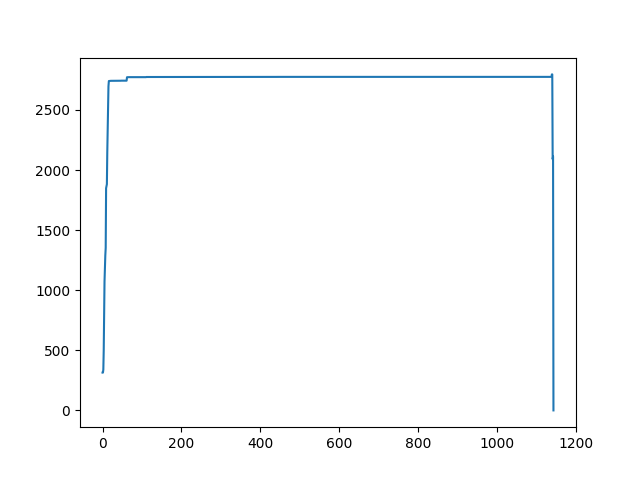

Mi sono reso conto di un errore nella preparazione del dataset: prendeva solo elementi della prima classe (ecco perché accuratezza del 100%). Codice aggiornato:

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.signal
import pickle

ds_ECG, ds_EEG, ds_GSR = {}, {}, {}
arousal, valence = [], []
#Removing subjects with missing data
excluded_subjects = [44, 52]
#Excluding subjects data with poor accuracy & many nan values

print("Loading subjects...", end=" ")
for i in range(37, 57):
    if(i not in excluded_subjects):
        clips_ECG = {}
        for j in range(1, 37):
            clips_ECG[('n_' + str(j))] = scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/ECGData/Movie_P' + str(i) + '/ECG_Clip' + str(j))['Data_ECG'][:,1:]
        ds_ECG[('S' + str(i))] = clips_ECG
        arousal.append(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/Dt_SelfReports.mat')['Ratings'][0][i])
        valence.append(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/Dt_SelfReports.mat')['Ratings'][1][i])
        clips_EEG = {}
        for j in range(1, 37):
            clips_EEG[('n_' + str(j))] = np.transpose(scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/EEGData/Movie_P' + str(i) + '/EEG_Clip' + str(j))['ThisEEG'][:,1:])
        ds_EEG[('S' + str(i))] = clips_EEG
        clips_GSR = {}
        for j in range(1, 37):
            clips_GSR[('n_' + str(j))] = scipy.io.loadmat('/home/fexed/ML/datasets/ASCERTAIN/GSRData/Movie_P' + str(i) + '/GSR_Clip' + str(j))['Data_GSR'][:,1:]
        ds_GSR[('S' + str(i))] = clips_GSR
print("done")

#4 classes:
#0 = arousal > 3 & valence > 0
#1 = arousal > 3 & valence <= 0
#2 = arousal <= 3 & valence > 0
#3 = arousal <= 3 & valence <= 0
print("Loading targets...", end=" ")
Y = []
for i in range(0, len(arousal)):
    for j in range(0, len(arousal[i])):
        if(arousal[i][j] > 3):
            if(valence[i][j]> 0):
                Y.append(0)
            elif(valence[i][j] <= 0):
                Y.append(1)
        elif(arousal[i][j] <= 3):
            if(valence[i][j] > 0):
                Y.append(2)
            elif(valence[i][j] <= 0):
                Y.append(3)
print("done")

print("Removing NaNs...", end=" ")
#Removing rows containing nan values
for s in ds_ECG.keys():
    for clip in ds_ECG[s].keys():
        ds_ECG[s][clip] = ds_ECG[s][clip][~np.isnan(ds_ECG[s][clip]).any(axis = 1)]
        ds_EEG[s][clip] = ds_EEG[s][clip][~np.isnan(ds_EEG[s][clip]).any(axis = 1)]
        ds_GSR[s][clip] = ds_GSR[s][clip][~np.isnan(ds_GSR[s][clip]).any(axis = 1)]
print("done")

print("Resampling...", end=" ")
#Resampling data to lower freq, 32 Hz
for s in ds_ECG.keys():
    for clip in ds_ECG[s].keys():
        ds_ECG[s][clip] = scipy.signal.resample(ds_ECG[s][clip], len(ds_EEG[s][clip]))
        ds_GSR[s][clip]= scipy.signal.resample(ds_GSR[s][clip], len(ds_EEG[s][clip]))
print("done")

#Merging features
ds = {}
i = 0
for s in ds_ECG.keys():
    clips = {}
    j = 0
    for clip in ds_ECG[s].keys():
        clips['Clip' + str(j)] = np.concatenate([
        ds_ECG[s][clip],
        ds_EEG[s][clip],
        ds_GSR[s][clip],
        ], axis = 1)
        j += 1
    ds['S' + str(i)] = clips
    i += 1
Y = (np.array(Y, dtype = np.float32)).reshape(-1, 36)

#Creating X and Y list of subsequences, length = 100 (3 seconds)
SubsequencesX, SubsequencesY = [], []
#Avoiding sampling bias
count_0, count_1, count_2, count_3 = 0, 0, 0, 0
i = 0
for s in ds.keys():
    j = 0
    for clip in ds[s].keys():
        #if(((Y[i][j] == 0) & (count_0 < 84)) or ((Y[i][j] == 1) & (count_1 < 84)) or ((Y[i][j] == 2) & (count_2 < 84)) or ((Y[i][j] == 3) & (count_3 < 84))):
       length = len(ds[s][clip])
       k = 0
       while (length - (100*(k+1))) > 0:
           SubsequencesX.append(ds[s][clip][length-(100*(k+1)):length-(100*k),:])
           if (Y[i][j] == 0):
                SubsequencesY.append(0)
           elif (Y[i][j] == 1):
                count_1 += 1
                SubsequencesY.append(1)
           elif (Y[i][j] == 2):
                count_2 += 1
                SubsequencesY.append(2)
           elif (Y[i][j] == 3):
                count_3 += 1
                SubsequencesY.append(3)
           k += 1
           print(Y[i][j])
       j += 1
    i += 1
    Xs = (np.array(SubsequencesX, dtype = np.float64)).reshape(-1, 100, 17)
    ys = tf.keras.utils.to_categorical(np.array(SubsequencesY, dtype = np.float32), num_classes = 4)
    print("Shape of X" + s + ":", Xs.shape)
    print("Shape of y" + s + ":", ys.shape)

    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/X" + s + ".pkl", 'wb') as handle:
        pickle.dump(Xs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/y" + s + ".pkl", 'wb') as handle:
        pickle.dump(ys, handle, protocol=pickle.HIGHEST_PROTOCOL)
    SubsequencesX, SubsequencesY = [], []


Rilancio il training offline, provando che un GRU da 30 non è sufficiente

`Media numero epoche: 10.0
Media tempo di addestramento: 560.08 s
Media accuracy: 34.760000000000005 %`

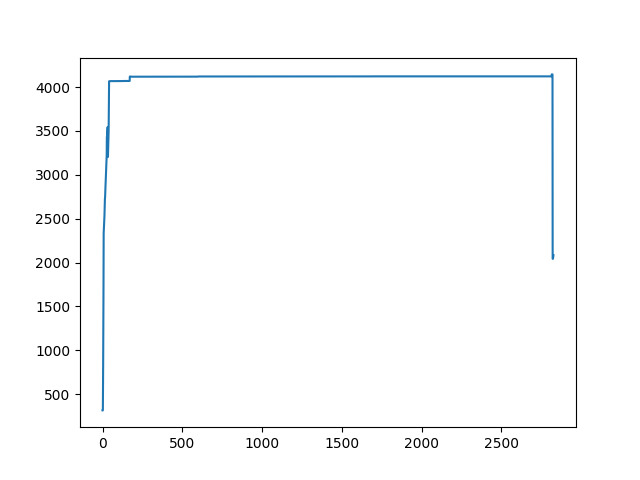

Dimostrato anche dal continual

`Media numero epoche: 19.25
Deviazione standard numero epoche: 8.41
Media tempo di addestramento: 745.77 s
Accuracy: [0.31960150599479675, 0.281637042760849, 0.37049004435539246, 0.2522886395454407, 0.27948305010795593, 0.4224555790424347, 0.4208400547504425, 0.41707053780555725] %
Media accuracy: 34.55 %
Deviazione standard accuracy: 6.63 %
ACC      0.2215
BWT      0.1222
FWT      0.0008`

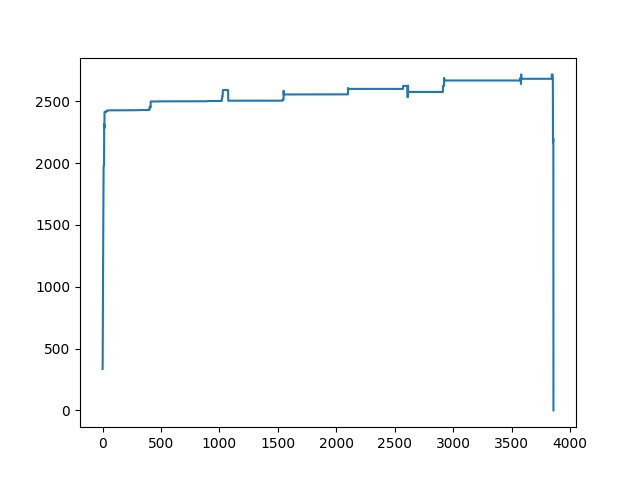

Provo la ricerca

#### 15 Luglio 2021

Dopo aver fatto una ricerca praticamente infruttuosa, ho lanciato il training offline ASCERTAIN con due layer GRU da 16 unità, come indicato da Disarli. Risultati pessimi (`2694`):

`Media numero epoche: 42.0
Media tempo di addestramento: 2286.64 s
Media accuracy: 29.24 %`

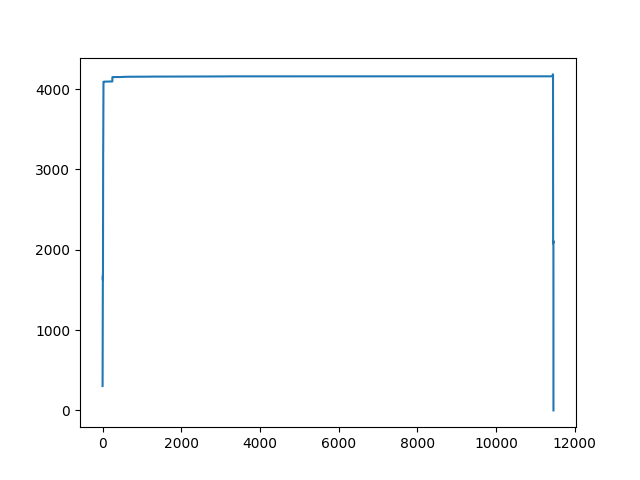

Provo un layer da 24 di nuovo, per ora da i risultati migliori (`14353`):

`Media numero epoche: 4.0
Media tempo di addestramento: 420.74 s
Media accuracy: 31.5 %`

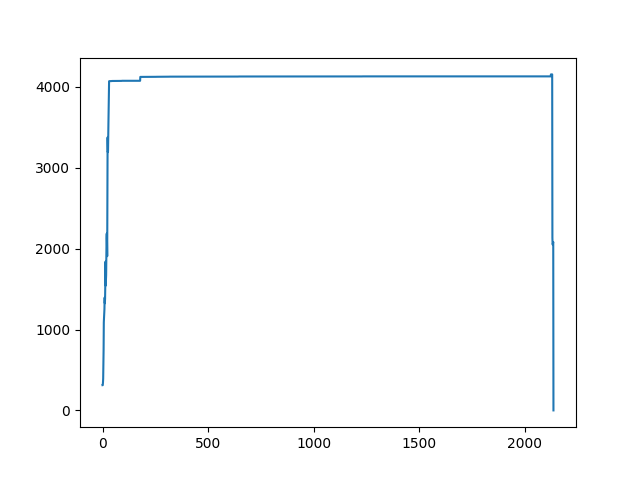

#### 16 Luglio 2021

Mi sono accorto di non aver standardizzato i dati ASCERTAIN, ho provveduto e rilanciato il training offline ma non sembra ottenere risultati molto migliori (GRU) (`ascertaintotal_1l_24u 30173`)

`Media numero epoche: 6.0
Media tempo di addestramento: 453.91 s
Media accuracy: 32.77 %`

Mentre con `ascertaintotal_2l_16u 32562`, sempre GRU

`Media numero epoche: 7.0
Media tempo di addestramento: 808.72 s
Media accuracy: 34.25 %`

Provo a vedere con sequenze da 160 com'era originalmente (`ascertaintotal_2l_16u 4325`, GRU)

`Media numero epoche: 8.0
Media tempo di addestramento: 757.13 s
Media accuracy: 35.88 %`

Mentre con un layer GRU da 24 (`ascertaintotal_1l_24u 8241`)

`Media numero epoche: 6.0
Media tempo di addestramento: 379.81 s
Media accuracy: 33.46 %`

Due layer GRU da 24 (`ascertaintotal_2l_24u 10259`)

`Media numero epoche: 4.0
Media tempo di addestramento: 619.61 s
Media accuracy: 39.37 %`

Provo il seguente modello (`ascertaintotal_lstm_1l_20u 13873`)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(160, 17)))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.99, beta_2 = 0.98)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

`Media numero epoche: 12.0
Media tempo di addestramento: 515.02 s
Media accuracy: 35.96 %`

Mentre con 5 layer LSTM da 8 unità (`ascertaintotal_lstm_5l_8u 18722`)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(8, return_sequences=True, input_shape=(160, 17)))
model.add(tf.keras.layers.LSTM(8, return_sequences=True))
model.add(tf.keras.layers.LSTM(8, return_sequences=True))
model.add(tf.keras.layers.LSTM(8, return_sequences=True))
model.add(tf.keras.layers.LSTM(8,))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

#### 17 Luglio 2021

Ieri sera c'è stato un blackout quindi non ha concluso il training, iniziato alle 17, dell'ultimo modello. Ho deciso che ora riprovo con il seguente modello single layer scelto da Disarli (`ascertaintotal_gru_2l_16u 987`):

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(16, return_sequences=True, input_shape=(160, 17)))
model.add(tf.keras.layers.GRU(16))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.95, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

`Media numero epoche: 10.0
Media tempo di addestramento: 884.81 s
Media accuracy: 32.30 %`

Mentre riprovando il singolo layer LSTM da 20 indicato sopra (`ascertaintotal_lstm_1l_20u 5575`):

`Media numero epoche: 7.0
Media tempo di addestramento: 392.29 s
Media accuracy: 35.58 %`

Un layer LSTM da 30 (`ascertaintotal_lstm_1l_30u 7657`):

`Media numero epoche: 4.0
Media tempo di addestramento: 327.46 s
Media accuracy: 35.32 %`

Un LSTM da 40 (`ascertaintotal_lstm_1l_40u 9399`):

`Media numero epoche: 4.0
Media tempo di addestramento: 371.11 s
Media accuracy: 34.54 %`

Un LSTM da 35 (`ascertaintotal_lstm_1l_35u 11361`):

`Media numero epoche: 6.0
Media tempo di addestramento: 432.97 s
Media accuracy: 36.09 %`

`ascertaintotal_lstm_1l_38u 13634`:

`Media numero epoche: 5.0
Media tempo di addestramento: 391.12 s
Media accuracy: 35.32 %`

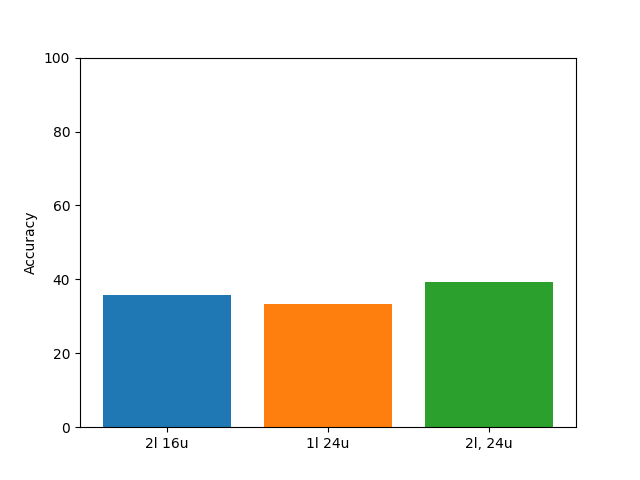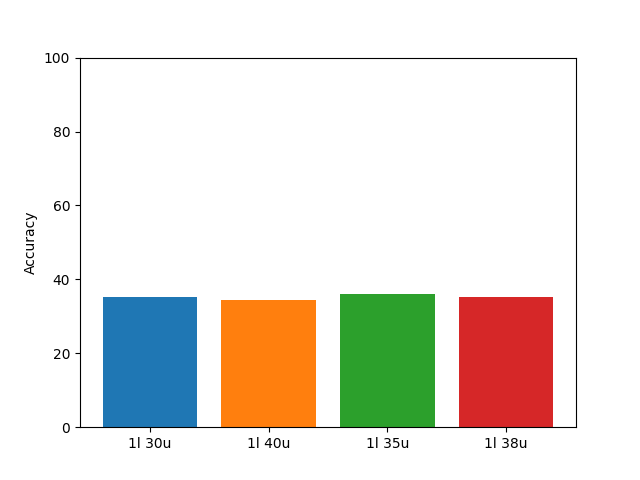

Ho quindi fatto l'autotest con GRU 2l 24u

`TOTAL TRAINING
Model... created
Dataset... loaded and splitted
Training in progress... and done
Numero epoche: 14.0
Media tempo di addestramento: 983.9 s
Accuracy: 35.27 %
Total model... saved`

`CONTINUAL TRAINING
Model... created
Training        started
Training        ended
Media numero epoche: 6.25
Deviazione standard numero epoche: 2.05
Media tempo di addestramento: 657.52 s
Accuracy: [0.2889176309108734, 0.29064252972602844, 0.35618799924850464, 0.3048727810382843, 0.35834410786628723, 0.4200086295604706, 0.38852953910827637, 0.3859422206878662] %
Media accuracy: 34.92 %
Deviazione standard accuracy: 4.62 %
ACC      0.2001
BWT      0.0042
FWT      -0.0044
Continual model... saved`

`CUMULATIVE TRAINING
Model... created
Training        started
Training        ended
Media numero epoche: 7.0
Deviazione standard numero epoche: 6.65
Media tempo di addestramento: 3163.95 s
Accuracy: [0.28331178426742554, 0.2902112901210785, 0.2988356947898865, 0.2712376117706299, 0.2889176309108734, 0.3247089385986328, 0.3436826169490814, 0.3742992579936981] %
Media accuracy: 30.94 %
Deviazione standard accuracy: 3.29 %
ACC      0.2001
BWT      0.0019
FWT      -0.0222
Cumulative model... saved`

#### 19 Luglio 2021

Voglio concludere l'autotest su ASCERTAIN, quindi ora lo rilancio ma facendolo direttamente partire dal replay training

`25% REPLAY TRAINING
Model... created
Training        started
Training        ended
Media numero epoche: 5.25
Deviazione standard numero epoche: 2.86
Media tempo di addestramento: 1001.82 s
Accuracy: [0.3005605936050415, 0.29150494933128357, 0.3363518714904785, 0.3091849982738495, 0.3574816584587097, 0.4156964123249054, 0.39068564772605896, 0.34842604398727417] %
Media accuracy: 34.37 %
Deviazione standard accuracy: 4.1000000000000005 %
ACC      0.249
BWT      0.0067
FWT      -0.0202`

`EPISODIC TRAINING
Media numero epoche: 6.5
Deviazione standard numero epoche: 2.78
Media tempo di addestramento: 916.44 s
Accuracy: [0.2923673987388611, 0.28719276189804077, 0.29581716656684875, 0.31263476610183716, 0.3290211260318756, 0.41483399271965027, 0.4122466444969177, 0.34023284912109375] %
Media accuracy: 33.550000000000004 %
Deviazione standard accuracy: 4.81 %
ACC      0.2098
BWT      -0.0311
FWT      0.0301`

`ascertain_lwf_gru_2l_24u 1373`

`Media numero epoche: 13.5
Deviazione standard numero epoche: 1.41
Media tempo di addestramento: 2217.32 s
Accuracy: [0.2880551815032959, 0.3061664402484894, 0.35618799924850464, 0.30659767985343933, 0.3501509130001068, 0.39801639318466187, 0.3863734304904938, 0.390254408121109] %
Media accuracy: 34.77 %
Deviazione standard accuracy: 4.01 %
ACC      0.2077
BWT      0.0278
FWT      -0.0316`

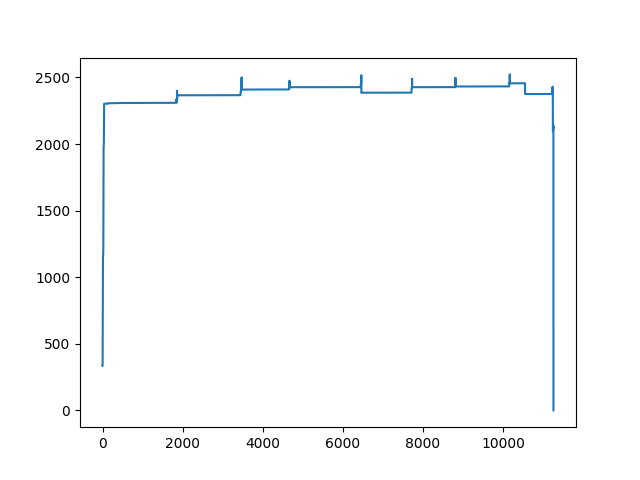

`ascertain_ewc_gru_2l_24u 13909`

`Media numero epoche: 28.88
Deviazione standard numero epoche: 14.72
Media tempo di addestramento: 3370.28 s
Accuracy: [0.299698144197464, 0.30099180340766907, 0.3605002164840698, 0.31090986728668213, 0.3311772346496582, 0.41310909390449524, 0.3859422206878662, 0.373436838388443] %
Media accuracy: 34.699999999999996 %
Deviazione standard accuracy: 3.9800000000000004 %
ACC      0.2327
BWT      0.0473
FWT      -0.0206`

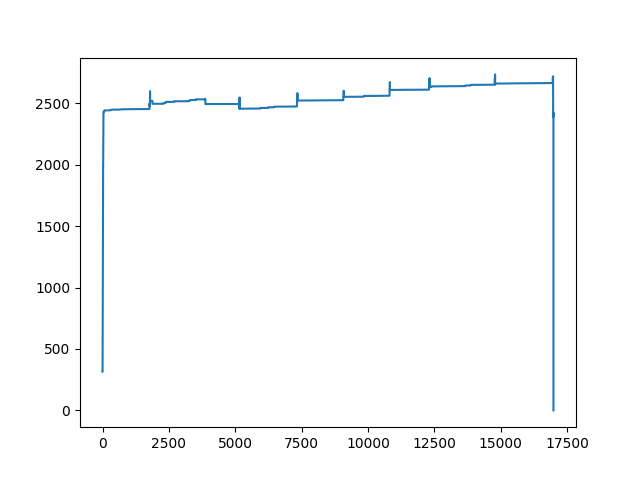

#### 20 Luglio 2021

Ho addestrato il modello generativo per ASCERTAIN, con il solito modello di WESAD (riadattato ovviamente):

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30))
model.add(tf.keras.layers.Dense(17,
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-6, l2 = 1e-6),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'mse', optimizer = opt)

e testandolo su un episodicGRU ha un'accuratezza del 25%, praticamente tira a caso.

Non volendo fare test a caso, ho raccolto __tutti__ i dati e compilato un <a href="https://docs.google.com/spreadsheets/d/1R-9iHnZLY-RvmS832B8gsKtio-NnxwZhSks13LAc408/edit#gid=919304856">foglio di calcolo</a>

#### 21 Luglio 2021

Inizio a fare gli esperimenti mancanti o di cui non ho tutte le misurazioni.

#### 22 Luglio 2021

Come ieri ma oggi tocca ad ASCERTAIN

#### 23 Luglio 2021

Finisco gli ultimi due training di ASCERTAIN, aggiorno l'Overleaf e parto con un layer LSTM da 30 per WESAD

#### 24 Luglio 2021

Finisco l'LWF per il layer LSTM da 30 per WESAD e inizio a cercare un modello LSTM per ASCERTAIN

#### 25 Luglio 2021

Continuo la ricerca di un modello LSTM performante per ASCERTAIN. Mi attesto su un layer LSTM da 35 e inizio i vari esperimenti

#### 26 Luglio 2021

Ultimi esperimenti con LSTM da 35 per ASCERTAIN

#### 28 Luglio 2021
##### Call w/ Lomonaco

- sistemare accuratezze
- partire con codice pari pari di Di Sarli
- ridimensionare dataset per vedere se migliora accuratezza
- verificare distribuzione classi
- verificare riproducibilità codice e pulirlo, commentare e tutto
- tesi latex dropbox/overleaf

Sono partito da WESAD, testando con l'attuale dataset e poi rifacendo sul dataset più snello con risultati simili o peggiori (ma io testo su S17). Ho avviato una `total_search`, dando come risultato `Best: 0.943820 using {'units': 29, 'layers': 3, 'kernel_regularizer': 1e-05, 'bias_regularizer': 1e-05, 'activity_regularizer': 0.0001}`

Ho quindi modificato il modello

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(29, return_sequences=True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(29, return_sequences=True))
model.add(tf.keras.layers.GRU(29))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-5),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Ma niente di buono. Altro modello da provare domani `0.872881 using {'units': 26, 'layers': 3, 'kernel_regularizer': 1e-05, 'bias_regularizer': 1e-05, 'activity_regularizer': 0.0001}`

#### 29 Luglio 2021

Nuovo modello

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(26, return_sequences=True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(26, return_sequences=True))
model.add(tf.keras.layers.GRU(26))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-05, l2 = 1e-05),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-05, l2 = 1e-05),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.85, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Ma neanche questo dà buoni risultati, provo

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(18, return_sequences=True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(18))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-05, l2 = 1e-05),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-05, l2 = 1e-05),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-06, l2 = 1e-06)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.008, beta_1 = 0.95, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Dopo varie search ecco che sbuca un altro modello

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(30, return_sequences=True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(30))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-06, l2 = 1e-06),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-04, l2 = 1e-04),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-06, l2 = 1e-06)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_2 = 0.98, beta_1 = 0.9)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Con il nuovo metodo di preparazione del dataset, ho `{(1.0, 0.0, 0.0, 0.0): 16, (0.0, 0.0, 1.0, 0.0): 16, (0.0, 0.0, 0.0, 1.0): 16, (0.0, 1.0, 0.0, 0.0): 16}` mentre col vecchio avevo `{(1.0, 0.0, 0.0, 0.0): 377, (0.0, 1.0, 0.0, 0.0): 231, (0.0, 0.0, 1.0, 0.0): 119, (0.0, 0.0, 0.0, 1.0): 107}`

Con un po' di fatica ho bilanciato meglio le classi, prendendo 100 esempi per ogni classe per ogni soggetto. Ora riprovo le ricerche.

Viene fuori il seguente modello:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(18, return_sequences=True, input_shape=(100, 14)))
model.add(tf.keras.layers.GRU(18, return_sequences=True))
model.add(tf.keras.layers.GRU(18))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-05, l2 = 1e-05),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-06, l2 = 1e-06),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-06, l2 = 1e-06)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.008, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

#### 30 Luglio 2021

Ieri non sono riuscito a trovare un modello con risultati soddisfacenti, oggi proseguo questa strada.

La mia conclusione è che la difficoltà sta nel classificare i dati di un solo soggetto invece di prendere dati dai soggetti precedenti. Mi spiego meglio: se uso solo S17 come soggetto di test, e il training lo eseguo sui soggetti precedenti, non riesco a classificare bene S17 perché è una persona nuova, diversa, con parametri diversi per le classi.

Potrei provare evitando la standardizzazione dei dati e vedere come si comporta così, cioè usando direttamente i dati "crudi" invece di standardizzarli.

`{'learning_rate': 0.005, 'beta_2': 0.99, 'beta_1': 0.99}`

#### 31 Luglio 2021

14.5h di ricerca, il risultato è `{'units': 15, 'layers': 3, 'kernel_regularizer': 0.0001, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001}`

#### 1 Agosto 2021

Ho provato altri modelli ma ancora nessun risultato soddisfacente. Rimango della mia idea, ma vedo se riesco a combinare qualcosa.

In serata, ho bilanciato ASCERTAIN. Domani provvedo a trovare modelli anche per lui

#### 2 Agosto 2021

Ho avviato la ricerca di layer e unità per ASCERTAIN con regolarizzatori = 0.0001, lr = 0.005 e entrambi i beta = 0.99

`Best: 0.416667 using {'units': 19, 'layers': 1}`

Risultati pessimi provo con regolarizzatori a 1-e06

Soluzione del problema suggerita da Lomonaco: usare come test set una partizione dell'intero dataset nel caso offline e S17 nei casi continual. Domani provvedo ai test, con le nuove impostazioni di training dovrei fare in una giornata.

#### 3 Agosto 2021

Avevo interpretato male la soluzione di Lomonaco. Quindi necessitando di un test set fisso ma che è partizione di tutti i soggetti, dovrei generare un test set in fase di preparazione del dataset e rimuovere dai vari soggetti i dati che vengono poi inseriti nel test set


In [ ]:
import pickle
import numpy as np
import copy
from collections import Counter
from sklearn.model_selection import train_test_split


X, y = None, None
for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]:
    Xs = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S + "_disarli.pkl", 'rb'), encoding='latin1')
    ys = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S + "_disarli.pkl", 'rb'), encoding='latin1')

    if (X is None):
        X = copy.deepcopy(Xs)
        y = copy.deepcopy(ys)
    else:
        X = np.concatenate([X, Xs], axis = 0)
        y = np.concatenate([y, ys], axis = 0)
    del Xs
    del ys
    print("Loaded " + S)

print("Dataset loaded")

print(str(X.shape) + " " + str(y.shape), end = " ")
_, Xts, _, yts = train_test_split(X, y, test_size = 0.25, train_size = 0.75, random_state=42)
print(str(Xts.shape) + " " + str(yts.shape))
with open("/home/fexed/ML/datasets/WESAD/splitted/Xts.pkl", 'wb') as handle:
    pickle.dump(Xts, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/home/fexed/ML/datasets/WESAD/splitted/yts.pkl", 'wb') as handle:
    pickle.dump(yts, handle, protocol=pickle.HIGHEST_PROTOCOL)

for S in ["S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "S14", "S15", "S16", "S17"]:
    Xs = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/X" + S + "_disarli.pkl", 'rb'), encoding='latin1')
    ys = pickle.load(open("/home/fexed/ML/datasets/WESAD/splitted/y" + S + "_disarli.pkl", 'rb'), encoding='latin1')
    print(S + " " + str(Xs.shape) + " " + str(ys.shape), end = " -> ")
    j = []
    for xts in Xts:
        for i, xs in enumerate(Xs):
            if (xts == xs).all():
                j.append(i)

    Xs = np.delete(Xs, j, axis = 0)
    ys = np.delete(ys, j, axis = 0)

    print(str(Xs.shape) + " " + str(ys.shape))
    with open("/home/fexed/ML/datasets/WESAD/splitted/X" + S + "_disarli.pkl", 'wb') as handle:
        pickle.dump(Xs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("/home/fexed/ML/datasets/WESAD/splitted/y" + S + "_disarli.pkl", 'wb') as handle:
        pickle.dump(ys, handle, protocol=pickle.HIGHEST_PROTOCOL)


Per __WESAD__:

`S2 (400, 100, 14) (400, 4) -> (287, 100, 14) (287, 4)
S3 (400, 100, 14) (400, 4) -> (287, 100, 14) (287, 4)
S4 (400, 100, 14) (400, 4) -> (298, 100, 14) (298, 4)
S5 (400, 100, 14) (400, 4) -> (298, 100, 14) (298, 4)
S6 (400, 100, 14) (400, 4) -> (297, 100, 14) (297, 4)
S7 (400, 100, 14) (400, 4) -> (303, 100, 14) (303, 4)
S8 (400, 100, 14) (400, 4) -> (309, 100, 14) (309, 4)
S9 (400, 100, 14) (400, 4) -> (292, 100, 14) (292, 4)
S10 (400, 100, 14) (400, 4) -> (313, 100, 14) (313, 4)
S11 (400, 100, 14) (400, 4) -> (292, 100, 14) (292, 4)
S13 (400, 100, 14) (400, 4) -> (308, 100, 14) (308, 4)
S14 (400, 100, 14) (400, 4) -> (297, 100, 14) (297, 4)
S15 (400, 100, 14) (400, 4) -> (305, 100, 14) (305, 4)
S16 (400, 100, 14) (400, 4) -> (313, 100, 14) (313, 4)
S17 (400, 100, 14) (400, 4) -> (301, 100, 14) (301, 4)`

In [ ]:
import pickle
import numpy as np
import copy
from collections import Counter
from sklearn.model_selection import train_test_split


X, y = None, None
for S in ["S0", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", "S13", "S14", "S15", "S16", "S17"]:
    Xs = pickle.load(open("/home/fexed/ML/datasets/ASCERTAIN/splitted/X" + S + ".pkl", 'rb'), encoding='latin1')
    ys = pickle.load(open("/home/fexed/ML/datasets/ASCERTAIN/splitted/y" + S + ".pkl", 'rb'), encoding='latin1')

    if (X is None):
        X = copy.deepcopy(Xs)
        y = copy.deepcopy(ys)
    else:
        X = np.concatenate([X, Xs], axis = 0)
        y = np.concatenate([y, ys], axis = 0)
    del Xs
    del ys
    print("Loaded " + S)

print("Dataset loaded")

print(str(X.shape) + " " + str(y.shape), end = " ")
_, Xts, _, yts = train_test_split(X, y, test_size = 0.25, train_size = 0.75, random_state=42)
print(str(Xts.shape) + " " + str(yts.shape))
with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/Xts.pkl", 'wb') as handle:
    pickle.dump(Xts, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/yts.pkl", 'wb') as handle:
    pickle.dump(yts, handle, protocol=pickle.HIGHEST_PROTOCOL)

for S in ["S0", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", "S13", "S14", "S15", "S16", "S17"]:
    Xs = pickle.load(open("/home/fexed/ML/datasets/ASCERTAIN/splitted/X" + S + ".pkl", 'rb'), encoding='latin1')
    ys = pickle.load(open("/home/fexed/ML/datasets/ASCERTAIN/splitted/y" + S + ".pkl", 'rb'), encoding='latin1')
    print(S + " " + str(Xs.shape) + " " + str(ys.shape), end = " -> ")
    j = []
    for xts in Xts:
        for i, xs in enumerate(Xs):
            if (xts == xs).all():
                j.append(i)

    Xs = np.delete(Xs, j, axis = 0)
    ys = np.delete(ys, j, axis = 0)

    print(str(Xs.shape) + " " + str(ys.shape))
    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/X" + S + ".pkl", 'wb') as handle:
        pickle.dump(Xs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("/home/fexed/ML/datasets/ASCERTAIN/splitted/y" + S + ".pkl", 'wb') as handle:
        pickle.dump(ys, handle, protocol=pickle.HIGHEST_PROTOCOL)


Per __ASCERTAIN__:

`S0 (336, 160, 17) (336, 4) -> (239, 160, 17) (239, 4)
S1 (252, 160, 17) (252, 4) -> (184, 160, 17) (184, 4)
S2 (336, 160, 17) (336, 4) -> (248, 160, 17) (248, 4)
S3 (336, 160, 17) (336, 4) -> (249, 160, 17) (249, 4)
S4 (336, 160, 17) (336, 4) -> (252, 160, 17) (252, 4)
S5 (336, 160, 17) (336, 4) -> (258, 160, 17) (258, 4)
S6 (336, 160, 17) (336, 4) -> (257, 160, 17) (257, 4)
S7 (336, 160, 17) (336, 4) -> (254, 160, 17) (254, 4)
S8 (336, 160, 17) (336, 4) -> (251, 160, 17) (251, 4)
S9 (336, 160, 17) (336, 4) -> (256, 160, 17) (256, 4)
S10 (324, 160, 17) (324, 4) -> (253, 160, 17) (253, 4)
S11 (240, 160, 17) (240, 4) -> (183, 160, 17) (183, 4)
S12 (336, 160, 17) (336, 4) -> (263, 160, 17) (263, 4)
S13 (336, 160, 17) (336, 4) -> (256, 160, 17) (256, 4)
S14 (336, 160, 17) (336, 4) -> (245, 160, 17) (245, 4)
S15 (336, 160, 17) (336, 4) -> (250, 160, 17) (250, 4)
S16 (336, 160, 17) (336, 4) -> (252, 160, 17) (252, 4)
S17 (300, 160, 17) (300, 4) -> (215, 160, 17) (215, 4)`

`Best: 0.287973 using {'learning_rate': 0.001, 'beta_2': 0.99, 'beta_1': 0.99}`

#### 4 Agosto 2021

Le ricerche hanno prodotto questo modello, per ASCERTAIN:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(27, return_sequences=True, input_shape=(160, 17)))
model.add(tf.keras.layers.GRU(27, return_sequences=True))
model.add(tf.keras.layers.GRU(27, return_sequences=True))
model.add(tf.keras.layers.GRU(27))
model.add(tf.keras.layers.Dense(4, activation = 'softmax',
                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  bias_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4),
                  activity_regularizer = tf.keras.regularizers.l1_l2(l1 = 1e-4, l2 = 1e-4)))
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.99, beta_2 = 0.99)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Esasperato dai pessimi risultati su ASCERTAIN, ho controllato ancora una volta i dati e mi sono accorto di una gestione sbagliata delle label (prendevo fondamentalmente sempre le stesse per ogni soggetto).

#### 5 Agosto 2021

Ce l'ho fatta, ASCERTAIN con accuratezza dell'87% circa. Faccio qualche ricerca per un modello migliore, poi dati e scrittura, finalmente.

Alla fine Lomonaco ha preferito l'approccio precedente, anche se a minore accuracy, perché non "mischio" i soggetti.

#### 6 Agosto 2021

Oggi si inizia a scrivere, per cui mi sa che da ora in poi passerò su Overleaf in pianta stabile.